In [1]:
# 1. 基本的なライブラリのインポート
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
import anndata as ad
from scipy import sparse
from scipy.spatial.distance import cdist, cosine
import umap
from tqdm.notebook import tqdm

# 2. PyTorch関連のインポートとデバイス設定
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

# デバイスの設定
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# 3. 乱数シードの設定（再現性のため）
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

# 4. 定数の定義
EPS = 1e-6

# 5. データセットとデータローダーの実装
class WTKODataset(Dataset):
    """WTとKOのscRNA-seqデータセット"""
    def __init__(self, data, labels=None):
        self.data = data
        self.labels = labels
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        if self.labels is not None:
            return self.data[idx], self.labels[idx]
        return self.data[idx]

def create_wt_ko_dataloaders(wt_data, wt_labels, ko_data, ko_labels, batch_size=64, shuffle=True):
    """WTとKOのデータローダーを作成"""
    # NumPy配列をTensorに変換
    if isinstance(wt_data, np.ndarray):
        wt_data = torch.tensor(wt_data, dtype=torch.float32)
    if isinstance(wt_labels, np.ndarray) and wt_labels is not None:
        wt_labels = torch.tensor(wt_labels, dtype=torch.long)
    if isinstance(ko_data, np.ndarray):
        ko_data = torch.tensor(ko_data, dtype=torch.float32)
    if isinstance(ko_labels, np.ndarray) and ko_labels is not None:
        ko_labels = torch.tensor(ko_labels, dtype=torch.long)
    
    # データセット作成
    wt_dataset = WTKODataset(wt_data, wt_labels)
    ko_dataset = WTKODataset(ko_data, ko_labels)
    
    # データローダー作成
    wt_loader = DataLoader(
        wt_dataset, 
        batch_size=batch_size,
        shuffle=shuffle,
        drop_last=False
    )
    
    ko_loader = DataLoader(
        ko_dataset, 
        batch_size=batch_size,
        shuffle=shuffle,
        drop_last=False
    )
    
    return wt_loader, ko_loader

# 6. 損失関数の実装
def symmetric_contrastive_loss(z_wt, z_ko, y_wt, y_ko, tau):
    """WTとKOの同一細胞タイプ間の対照損失"""
    # 共通の細胞タイプを特定
    shared_labels = set(y_wt.unique().cpu().tolist()).intersection(set(y_ko.unique().cpu().tolist()))
    
    total_loss = 0.0
    num_shared_types = 0
    
    for c in shared_labels:
        # 同じ細胞タイプのインデックスを抽出
        idx_wt = (y_wt == c).nonzero(as_tuple=True)[0]
        idx_ko = (y_ko == c).nonzero(as_tuple=True)[0]
        
        if len(idx_wt) == 0 or len(idx_ko) == 0:
            continue
            
        # 同じ細胞タイプの潜在表現を抽出
        zc_wt = z_wt[idx_wt]
        zc_ko = z_ko[idx_ko]
        
        # WT -> KO方向の非対称損失
        sim_matrix = torch.mm(zc_wt, zc_ko.T) / tau
        loss_wt_ko = -torch.log(
            torch.exp(sim_matrix) / 
            torch.exp(sim_matrix).sum(dim=1, keepdim=True)
        ).mean()
        
        # KO -> WT方向の非対称損失
        sim_matrix = torch.mm(zc_ko, zc_wt.T) / tau
        loss_ko_wt = -torch.log(
            torch.exp(sim_matrix) / 
            torch.exp(sim_matrix).sum(dim=1, keepdim=True)
        ).mean()
        
        # 対称的損失
        cell_type_loss = (loss_wt_ko + loss_ko_wt) / 2
        total_loss += cell_type_loss
        num_shared_types += 1
    
    if num_shared_types == 0:
        return torch.tensor(0.0, device=z_wt.device)
    
    return total_loss / num_shared_types

def cluster_alignment_loss(z, y):
    """同一細胞タイプの潜在表現をクラスタ中心に引き寄せる正則化項"""
    unique_labels = torch.unique(y)
    total_loss = 0.0
    
    for c in unique_labels:
        # 同じ細胞タイプのインデックスを抽出
        idx = (y == c).nonzero(as_tuple=True)[0]
        if len(idx) == 0:
            continue
            
        # 同じ細胞タイプの潜在表現を抽出
        zc = z[idx]
        
        # クラスタ中心（重心）を計算
        mu_c = zc.mean(dim=0)
        
        # 中心からの距離の二乗和
        loss = ((zc - mu_c.unsqueeze(0)) ** 2).sum() / len(idx)
        total_loss += loss
    
    return total_loss / len(unique_labels)

# 7. モデル構築用ヘルパー関数
def get_fully_connected_layers(input_dim, output_dim, hidden_dims, norm_type='batch', dropout_prob=0.1):
    """完全連結層のシーケンスを作成するヘルパー関数"""
    layers = []
    dims = [input_dim] + list(hidden_dims) + [output_dim]
    
    for i in range(len(dims) - 1):
        layers.append(nn.Linear(dims[i], dims[i+1]))
        
        # 最後の層以外に正規化とドロップアウトを追加
        if i < len(dims) - 2:
            if norm_type == 'batch':
                layers.append(nn.BatchNorm1d(dims[i+1]))
            elif norm_type == 'layer':
                layers.append(nn.LayerNorm(dims[i+1]))
            
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout_prob))
    
    return nn.Sequential(*layers)

# 8. モデルの実装
class WTKOContrastiveVAE(nn.Module):
    """WTとKOのデータを対照学習するVAEモデル"""
    def __init__(self, input_dim, latent_dim=10, hidden_dims=(128,), 
                 tau=0.1, lambda_contrast=1.0, lambda_align=0.5, 
                 dropout_prob=0.1, norm_type='batch'):
        super().__init__()
        
        # エンコーダネットワーク
        self.encoder = get_fully_connected_layers(
            input_dim, latent_dim, hidden_dims, 
            norm_type=norm_type, dropout_prob=dropout_prob
        )
        
        # 濃度パラメータネットワーク
        self.kappa_encoder = get_fully_connected_layers(
            input_dim, 1, hidden_dims, 
            norm_type=norm_type, dropout_prob=dropout_prob
        )
        
        # デコーダネットワーク
        self.decoder = get_fully_connected_layers(
            latent_dim, input_dim, hidden_dims,
            norm_type=norm_type, dropout_prob=dropout_prob
        )
        
        # ハイパーパラメータ
        self.tau = tau
        self.lambda_contrast = lambda_contrast
        self.lambda_align = lambda_align
        self.latent_dim = latent_dim
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
    def encode(self, x):
        """エンコーダを通して分布のパラメータを取得"""
        mu = self.encoder(x)
        # L2正規化して単位球面上に拘束
        mu = F.normalize(mu, p=2, dim=1)
        # 濃度パラメータを計算
        kappa = F.softplus(self.kappa_encoder(x)) + EPS
        return mu, kappa
    
    def sample_z(self, mu, kappa):
        """球面分布からサンプリング (学習時は確率的、推論時は決定的)"""
        # 訓練時はランダム性を加え、推論時は平均値を使用
        if self.training:
            # 単純な近似: 平均方向にランダムなノイズを加える
            noise = torch.randn_like(mu) * torch.exp(-kappa)
            z = mu + noise
            z = F.normalize(z, p=2, dim=1)
            return None, z
        else:
            return None, mu
    
    def decode(self, z):
        """デコーダを通して再構成"""
        return self.decoder(z)
    
    def forward(self, data_dict):
        """モデルの順伝播"""
        # データの展開
        wt_x = data_dict['wt_x']
        ko_x = data_dict['ko_x']
        wt_labels = data_dict['wt_labels']
        ko_labels = data_dict['ko_labels']
        
        # エンコード
        wt_mu, wt_kappa = self.encode(wt_x)
        ko_mu, ko_kappa = self.encode(ko_x)
        
        # サンプリング
        _, wt_z = self.sample_z(wt_mu, wt_kappa)
        _, ko_z = self.sample_z(ko_mu, ko_kappa)
        
        # デコード
        wt_x_recon = self.decode(wt_z)
        ko_x_recon = self.decode(ko_z)
        
        # 再構成損失
        recon_loss = F.mse_loss(wt_x_recon, wt_x) + F.mse_loss(ko_x_recon, ko_x)
        
        # KLダイバージェンス (簡略化)
        kl_loss = (wt_kappa.mean() + ko_kappa.mean()) * 0.01
        
        # コントラスト損失
        contrast_loss = symmetric_contrastive_loss(wt_z, ko_z, wt_labels, ko_labels, self.tau)
        
        # クラスタ整列損失
        combined_z = torch.cat([wt_z, ko_z], dim=0)
        combined_labels = torch.cat([wt_labels, ko_labels], dim=0)
        align_loss = cluster_alignment_loss(combined_z, combined_labels)
        
        # 総損失
        total_loss = recon_loss + kl_loss + self.lambda_contrast * contrast_loss + self.lambda_align * align_loss
        
        return {
            'loss': total_loss,
            'recon_loss': recon_loss,
            'kl_loss': kl_loss,
            'contrast_loss': contrast_loss,
            'align_loss': align_loss,
            'wt_z': wt_z,
            'ko_z': ko_z
        }
    
    def encode_data(self, x):
        """データをエンコードして潜在表現を取得（推論用）"""
        mu, kappa = self.encode(x)
        _, z = self.sample_z(mu, kappa)
        return z
    
    def reconstruct_data(self, x):
        """データを再構成（推論用）"""
        z = self.encode_data(x)
        return self.decode(z)

# 9. トレーナークラスの実装
class WTKOTrainer:
    """WTKOContrastiveVAEモデルを訓練するためのクラス"""
    def __init__(self, model, device=None):
        self.model = model
        self.device = device if device is not None else torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.model.to(self.device)
        
    def train(self, 
              wt_loader, 
              ko_loader, 
              num_epochs=100, 
              lr=1e-3, 
              weight_decay=1e-5, 
              save_path=None, 
              verbose=True):
        """モデルの学習を実行"""
        optimizer = torch.optim.Adam(self.model.parameters(), lr=lr, weight_decay=weight_decay)
        
        # 学習履歴
        history = {
            'loss': [],
            'recon_loss': [],
            'kl_loss': [],
            'contrast_loss': [],
            'align_loss': []
        }
        
        # メインの進捗バー（エポック用）
        epoch_bar = tqdm(range(num_epochs), desc="Training")
        
        # 学習ループ
        for epoch in epoch_bar:
            self.model.train()
            epoch_losses = {k: 0.0 for k in history.keys()}
            num_batches = min(len(wt_loader), len(ko_loader))
            
            # データローダーの反復子を取得
            wt_iter = iter(wt_loader)
            ko_iter = iter(ko_loader)
            
            for _ in range(num_batches):
                # バッチデータの取得
                try:
                    wt_batch = next(wt_iter)
                    ko_batch = next(ko_iter)
                except StopIteration:
                    break
                
                # デバイスに転送
                wt_x = wt_batch[0].to(self.device)
                wt_labels = wt_batch[1].to(self.device)
                ko_x = ko_batch[0].to(self.device)
                ko_labels = ko_batch[1].to(self.device)
                
                # データ辞書の作成
                data_dict = {
                    'wt_x': wt_x,
                    'ko_x': ko_x,
                    'wt_labels': wt_labels,
                    'ko_labels': ko_labels
                }
                
                # 勾配のリセット
                optimizer.zero_grad()
                
                # 順伝播
                output = self.model(data_dict)
                
                # 損失計算
                loss = output['loss']
                
                # 逆伝播と最適化
                loss.backward()
                optimizer.step()
                
                # 損失の記録
                for k in epoch_losses.keys():
                    epoch_losses[k] += output[k].item() if k in output else 0.0
            
            # エポック平均損失
            for k in epoch_losses.keys():
                epoch_losses[k] /= num_batches
                history[k].append(epoch_losses[k])
            
            # 進捗バーの説明を更新
            epoch_bar.set_postfix({
                'loss': f"{epoch_losses['loss']:.4f}",
                'recon': f"{epoch_losses['recon_loss']:.4f}",
                'contrast': f"{epoch_losses['contrast_loss']:.4f}"
            })
            
            # モデル保存（オプション）
            if save_path is not None and (epoch + 1) % 10 == 0:
                save_dir = os.path.dirname(save_path)
                if not os.path.exists(save_dir):
                    os.makedirs(save_dir)
                save_file = f"{save_path}_epoch_{epoch+1}.pt"
                torch.save(self.model.state_dict(), save_file)
        
        # 最終モデル保存（オプション）
        if save_path is not None:
            save_dir = os.path.dirname(save_path)
            if not os.path.exists(save_dir):
                os.makedirs(save_dir)
            save_file = f"{save_path}_final.pt"
            torch.save(self.model.state_dict(), save_file)
            
        return history
    
    def get_latent_representations(self, loader):
        """データの潜在表現を取得"""
        self.model.eval()
        latent_reps = []
        labels = []
        
        with torch.no_grad():
            for batch in loader:
                x = batch[0].to(self.device)
                if len(batch) > 1:
                    y = batch[1].to(self.device)
                    labels.append(y)
                
                z = self.model.encode_data(x)
                latent_reps.append(z)
        
        latent_reps = torch.cat(latent_reps, dim=0)
        
        if len(labels) > 0:
            labels = torch.cat(labels, dim=0)
            return latent_reps, labels
        
        return latent_reps

# 10. シミュレーションデータ生成と前処理用の関数
def check_nans(adata, name="dataset"):
    """AnnDataオブジェクト内のNaN値をチェック"""
    if sparse.issparse(adata.X):
        x_nan_count = np.isnan(adata.X.data).sum()
    else:
        x_nan_count = np.isnan(adata.X).sum()
    
    print(f"{name} X NaN count: {x_nan_count}")
    
    if 'velocity' in adata.layers:
        if sparse.issparse(adata.layers['velocity']):
            v_nan_count = np.isnan(adata.layers['velocity'].data).sum()
        else:
            v_nan_count = np.isnan(adata.layers['velocity']).sum()
        print(f"{name} velocity NaN count: {v_nan_count}")

def generate_simulation_data(n_cells_wt=1000, n_cells_ko=1000, n_genes=2000, n_cell_types=5, noise_level=0.1):
    """改良版：NaNや0カウントの問題を回避するWTとKO細胞のシミュレーションデータ生成"""
    # 細胞タイプごとの発現プロファイルを生成（ReLU関数を適用して負の値を0に）
    cell_type_profiles = np.maximum(np.random.normal(0, 1, (n_cell_types, n_genes)), 0)
    
    # 各細胞タイプに対して少なくともいくつかの遺伝子が発現するようにする
    min_expressed_genes = 100  # 各細胞タイプで最低発現する遺伝子数
    for i in range(n_cell_types):
        # ランダムに遺伝子を選択して発現量を上げる
        expressed_genes = np.random.choice(n_genes, min_expressed_genes, replace=False)
        cell_type_profiles[i, expressed_genes] = np.maximum(cell_type_profiles[i, expressed_genes], 0.5)
    
    # WT細胞の割り当て
    wt_cell_types = np.random.randint(0, n_cell_types, n_cells_wt)
    ko_cell_types = np.random.randint(0, n_cell_types, n_cells_ko)
    
    # 細胞タイプラベルの作成
    wt_cell_type_names = [f"CellType_{i}" for i in wt_cell_types]
    ko_cell_type_names = [f"CellType_{i}" for i in ko_cell_types]
    
    # 細胞タイプに基づいて発現データを生成
    wt_data = np.zeros((n_cells_wt, n_genes))
    ko_data = np.zeros((n_cells_ko, n_genes))
    
    for i in range(n_cells_wt):
        # ノイズは正の値のみ
        noise = np.abs(np.random.normal(0, noise_level, n_genes))
        wt_data[i] = cell_type_profiles[wt_cell_types[i]] + noise
    
    for i in range(n_cells_ko):
        # KOの影響
        profile = cell_type_profiles[ko_cell_types[i]].copy()
        
        # KOの影響: 特定の遺伝子セットに影響がある場合を仮定
        ko_effect_genes = np.random.choice(n_genes, size=int(n_genes * 0.1), replace=False)
        profile[ko_effect_genes] *= 0.5  # 発現の減少
        
        # ノイズは正の値のみ
        noise = np.abs(np.random.normal(0, noise_level, n_genes))
        ko_data[i] = profile + noise
    
    # さらに、0カウントの細胞がないことを確認
    min_count = 1e-6
    wt_data = np.maximum(wt_data, min_count)
    ko_data = np.maximum(ko_data, min_count)
    
    # RNA velocity のシミュレーション（単純な例として現在の発現状態からのランダムな変化）
    wt_velocity = np.random.normal(0, 0.1, (n_cells_wt, n_genes))
    ko_velocity = np.random.normal(0, 0.1, (n_cells_ko, n_genes))
    
    # 細胞タイプ特異的な速度パターンの追加
    for ct in range(n_cell_types):
        wt_ct_mask = wt_cell_types == ct
        ko_ct_mask = ko_cell_types == ct
        
        # 細胞タイプ特異的な方向性を持つ速度ベクトル
        ct_velocity_pattern = np.random.normal(0, 1, n_genes)
        
        # WTの速度ベクトルに適用
        wt_velocity[wt_ct_mask] += ct_velocity_pattern * 0.2
        
        # KO特異的な速度変化
        ko_velocity_pattern = ct_velocity_pattern.copy()
        ko_effect_genes = np.random.choice(n_genes, size=int(n_genes * 0.1), replace=False)
        ko_velocity_pattern[ko_effect_genes] *= -1  # 反対方向に変化
        
        # KOの速度ベクトルに適用
        ko_velocity[ko_ct_mask] += ko_velocity_pattern * 0.2
    
    # AnnDataオブジェクトの作成
    adata_wt = ad.AnnData(X=wt_data)
    adata_ko = ad.AnnData(X=ko_data)
    
    # 細胞タイプ情報の追加
    adata_wt.obs['cell_type'] = pd.Categorical(wt_cell_type_names)
    adata_ko.obs['cell_type'] = pd.Categorical(ko_cell_type_names)
    
    # RNA velocityの追加
    adata_wt.layers['velocity'] = wt_velocity
    adata_ko.layers['velocity'] = ko_velocity
    
    return adata_wt, adata_ko

# 11. 可視化用ヘルパー関数
def project_velocity_to_2d(points, velocity, embeddings):
    """速度ベクトルを簡易的に2D空間に射影"""
    n_points = len(points)
    # ランダムな方向の単位ベクトル（デモ用）
    angles = np.random.uniform(0, 2 * np.pi, n_points)
    vx = np.cos(angles) * 0.05
    vy = np.sin(angles) * 0.05
    
    return np.column_stack([vx, vy])

Using device: cuda


データ読み込み

In [2]:
import scanpy as sc
import os

# 読み込むファイルのパス
adata_path = r"C:\Users\kohei\Desktop\Velo_compare\VC_code_dir\キメラ_annotated_with_subcelltypes.h5ad"

# AnnDataオブジェクトの読み込み
adata = sc.read_h5ad(adata_path)

# 確認用：読み込んだオブジェクトの概要を表示
print(adata)
print("obs columns:", adata.obs.columns.tolist())

AnnData object with n_obs × n_vars = 18233 × 29453
    obs: 'Sample', 'Barcode', 'Pool', 'Sequence', 'Sample.name', 'CellName', 'is_cell_control', 'total_features_by_counts', 'log10_total_features_by_counts', 'total_counts', 'log10_total_counts', 'pct_counts_in_top_50_features', 'pct_counts_in_top_100_features', 'pct_counts_in_top_200_features', 'pct_counts_in_top_500_features', 'total_features_by_counts_endogenous', 'log10_total_features_by_counts_endogenous', 'total_counts_endogenous', 'log10_total_counts_endogenous', 'pct_counts_endogenous', 'pct_counts_in_top_50_features_endogenous', 'pct_counts_in_top_100_features_endogenous', 'pct_counts_in_top_200_features_endogenous', 'pct_counts_in_top_500_features_endogenous', 'total_features_by_counts_feature_control', 'log10_total_features_by_counts_feature_control', 'total_counts_feature_control', 'log10_total_counts_feature_control', 'pct_counts_feature_control', 'pct_counts_in_top_50_features_feature_control', 'pct_counts_in_top_100_feat

In [3]:
# 抽出したい haem_subclust 群のリスト
blood_subclusters = [
    "BP1", "BP2", "BP3", "BP4",
    "Ery1", "Ery2", "Ery3", "Ery4",
    "Haem1", "Haem2", "Haem3", "Haem4",
    "Mk", "My", "EC"
]

# フィルタリング（該当するサブクラスタのみ抽出）
adata_blood = adata[adata.obs["haem_subclust_grouped"].isin(blood_subclusters)].copy()

# 結果確認
print(f"血液系サブクラスタの細胞数: {adata_blood.n_obs}")
print("抽出後の haem_subclust_grouped 分布:")
print(adata_blood.obs["haem_subclust_grouped"].value_counts())


血液系サブクラスタの細胞数: 4374
抽出後の haem_subclust_grouped 分布:
haem_subclust_grouped
EC       915
BP2      800
Ery1     760
Ery2     731
Ery3     229
Haem2    174
Ery4     154
BP3      141
Mk       103
BP1       90
Haem3     69
My        65
BP4       64
Haem4     57
Haem1     22
Name: count, dtype: int64


In [4]:
# KO（tomatoが"pos"）の細胞を抽出
adata_ko = adata_blood[adata_blood.obs["tomato"] == "pos"].copy()

# WT（tomatoが"neg"）の細胞を抽出
adata_wt = adata_blood[adata_blood.obs["tomato"] == "neg"].copy()

# 結果の確認
print(f"KO 細胞数: {adata_ko.n_obs}")
print(f"WT 細胞数: {adata_wt.n_obs}")

KO 細胞数: 2284
WT 細胞数: 2090


In [5]:
# === MURK遺伝子の除外 ===
murk_path = r"C:\Users\kohei\Desktop\Velo_compare\murk_genes_mouse.csv"
murk_genes = pd.read_csv(murk_path, header=None)[0].tolist()

# 各群から MURK 遺伝子を除外（存在する遺伝子のみ考慮）
valid_murk_genes_ko = [g for g in murk_genes if g in adata_ko.var_names]
valid_murk_genes_wt = [g for g in murk_genes if g in adata_wt.var_names]

adata_ko = adata_ko[:, [g for g in adata_ko.var_names if g not in valid_murk_genes_ko]].copy()
adata_wt = adata_wt[:, [g for g in adata_wt.var_names if g not in valid_murk_genes_wt]].copy()

print(f"除外後 KO の遺伝子数: {adata_ko.n_vars}")
print(f"除外後 WT の遺伝子数: {adata_wt.n_vars}")

除外後 KO の遺伝子数: 29365
除外後 WT の遺伝子数: 29365


In [6]:
import scvelo as scv
from velovi import VELOVI
import numpy as np
import pandas as pd
from scipy import sparse

def apply_velovi_to_group(adata, group_name, max_epochs=1000, min_r2=-10, gamma=-10):
    """
    VELOVI を適用して velocity を計算し、フィルタ済み AnnData を返す
    """
    print(f"\n=== Processing {group_name} with VELOVI ===")

    # 元の X を保持（必要なら）
    adata_copy = adata.copy()
    # = adata.var_names.copy()

    # scVelo 前処理
    scv.pp.filter_and_normalize(adata_copy, min_shared_counts=20, n_top_genes=40000, enforce=True)
    scv.pp.moments(adata_copy, n_neighbors=30, n_pcs=50, method='umap')

    # 初期 velocity 推定（フィルタ指標用）
    scv.tl.velocity(
        adata_copy,
        mode="dynamical",
        min_r2=min_r2,
        gamma=gamma,
        filter_genes=False,
        use_highly_variable=False
    )

    # 遺伝子フィルタ条件を定義
    mask = (adata_copy.var.velocity_r2 > min_r2) & (adata_copy.var.velocity_gamma > gamma)

    print(f"遺伝子数（元）: {adata_copy.n_vars}")
    print(f"velocity_r2 > {min_r2}: {np.sum(adata_copy.var.velocity_r2 > min_r2)}")
    print(f"gamma > {gamma}: {np.sum(adata_copy.var.velocity_gamma > gamma)}")
    print(f"両方を満たす遺伝子数: {mask.sum()}")

    # フィルタリング適用
    filtered_adata = adata_copy[:, mask].copy()

    # VELOVI セットアップと学習
    VELOVI.setup_anndata(filtered_adata, spliced_layer="Ms", unspliced_layer="Mu")
    model = VELOVI(filtered_adata)
    model.train(max_epochs=max_epochs)

    # 推定速度を格納
    velocity_estimates = model.get_velocity()
    filtered_adata.layers["velocity"] = velocity_estimates

    # velocity graph を計算
    scv.tl.velocity_graph(filtered_adata)

    # UMAPなどのobsmを保持
    for key in adata.obsm.keys():
        if key not in filtered_adata.obsm:
            filtered_adata.obsm[key] = adata.obsm[key]

    return filtered_adata, model

def align_gene_sets(adata_wt, adata_ko):
    """
    WTとKOのAnnDataオブジェクトの遺伝子セットを揃える
    実際に存在する遺伝子名のみを使用
    """
    print("\n=== 遺伝子セットの調整 ===")
    
    # 現在の遺伝子セット
    wt_genes = list(adata_wt.var_names)
    ko_genes = list(adata_ko.var_names)
    
    print(f"WT遺伝子数: {len(wt_genes)}")
    print(f"KO遺伝子数: {len(ko_genes)}")
    
    # 共通の遺伝子セットを特定
    common_genes = list(set(wt_genes).intersection(set(ko_genes)))
    print(f"共通遺伝子数: {len(common_genes)}")
    
    if len(common_genes) == 0:
        print("警告：WTとKOの間に共通の遺伝子がありません")
        # 最低限の処理を続行するため、各データセットから少数の遺伝子を選択
        common_genes = wt_genes[:min(len(wt_genes), 100)]
    
    # 共通遺伝子のみに絞り込み
    print("共通遺伝子に絞り込みます...")
    wt_aligned = adata_wt[:, common_genes].copy()
    ko_aligned = adata_ko[:, common_genes].copy()
    
    print(f"調整後のWT遺伝子数: {wt_aligned.n_vars}")
    print(f"調整後のKO遺伝子数: {ko_aligned.n_vars}")
    
    return wt_aligned, ko_aligned

def process_and_align_data(adata_wt, adata_ko):
    # VELOVI適用
    print("VELOVIをWT群に適用中...")
    adata_wt_filtered, model_wt = apply_velovi_to_group(adata_wt.copy(), "WT")
    
    print("VELOVIをKO群に適用中...")
    adata_ko_filtered, model_ko = apply_velovi_to_group(adata_ko.copy(), "KO")
    
    # 遺伝子セットの調整
    print("遺伝子セットを調整中...")
    adata_wt_aligned, adata_ko_aligned = align_gene_sets(
        adata_wt_filtered, adata_ko_filtered
    )
    
    return adata_wt_aligned, adata_ko_aligned, model_wt, model_ko


# メイン処理
adata_wt_aligned, adata_ko_aligned, model_wt, model_ko = process_and_align_data(adata_wt, adata_ko)

VELOVIをWT群に適用中...

=== Processing WT with VELOVI ===
Filtered out 21368 genes that are detected 20 counts (shared).
Normalized count data: X, spliced, unspliced.
Skip filtering by dispersion since number of variables are less than `n_top_genes`.
Logarithmized X.


c:\Users\kohei\Desktop\Velo_compare\VC_env\lib\site-packages\scvelo\preprocessing\utils.py:705: DeprecationWarning: `log1p` is deprecated since scVelo v0.3.0 and will be removed in a future version. Please use `log1p` from `scanpy.pp` instead.
  log1p(adata)
C:\Users\kohei\AppData\Local\Temp\ipykernel_32688\636786722.py:19: DeprecationWarning: Automatic neighbor calculation is deprecated since scvelo==0.4.0 and will be removed in a future version of scVelo. Please compute neighbors first with Scanpy.
  scv.pp.moments(adata_copy, n_neighbors=30, n_pcs=50, method='umap')
c:\Users\kohei\Desktop\Velo_compare\VC_env\lib\site-packages\scvelo\preprocessing\moments.py:71: DeprecationWarning: `neighbors` is deprecated since scvelo==0.4.0 and will be removed in a future version of scVelo. Please compute neighbors with Scanpy.
  neighbors(
c:\Users\kohei\Desktop\Velo_compare\VC_env\lib\site-packages\scvelo\preprocessing\neighbors.py:233: DeprecationWarning: Automatic computation of PCA is depreca

computing neighbors


  File "c:\Users\kohei\Desktop\Velo_compare\VC_env\lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
  File "C:\Users\kohei\AppData\Local\Programs\Python\Python39\lib\subprocess.py", line 505, in run
    with Popen(*popenargs, **kwargs) as process:
  File "C:\Users\kohei\AppData\Local\Programs\Python\Python39\lib\subprocess.py", line 951, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "C:\Users\kohei\AppData\Local\Programs\Python\Python39\lib\subprocess.py", line 1420, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(executable, args,


    finished (0:00:02) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:02) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
computing velocities


c:\Users\kohei\Desktop\Velo_compare\VC_env\lib\site-packages\scvelo\tools\optimization.py:184: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  gamma[i] = np.linalg.pinv(A.T.dot(A)).dot(A.T.dot(y[:, i]))


    finished (0:00:05) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
遺伝子数（元）: 7997
velocity_r2 > -10: 7993
gamma > -10: 7997
両方を満たす遺伝子数: 7993


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4060 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 809/1000:  81%|████████  | 809/1000 [14:46<03:29,  1.10s/it, v_num=1, train_loss_step=-1.07e+4, train_loss_epoch=-1.07e+4]
Monitored metric elbo_validation did not improve in the last 45 records. Best score: -9679.670. Signaling Trainer to stop.
computing velocity graph (using 1/20 cores)


  0%|          | 0/2090 [00:00<?, ?cells/s]

    finished (0:01:26) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
VELOVIをKO群に適用中...

=== Processing KO with VELOVI ===
Filtered out 20915 genes that are detected 20 counts (shared).
Normalized count data: X, spliced, unspliced.
Skip filtering by dispersion since number of variables are less than `n_top_genes`.
Logarithmized X.


c:\Users\kohei\Desktop\Velo_compare\VC_env\lib\site-packages\scvelo\preprocessing\utils.py:705: DeprecationWarning: `log1p` is deprecated since scVelo v0.3.0 and will be removed in a future version. Please use `log1p` from `scanpy.pp` instead.
  log1p(adata)
C:\Users\kohei\AppData\Local\Temp\ipykernel_32688\636786722.py:19: DeprecationWarning: Automatic neighbor calculation is deprecated since scvelo==0.4.0 and will be removed in a future version of scVelo. Please compute neighbors first with Scanpy.
  scv.pp.moments(adata_copy, n_neighbors=30, n_pcs=50, method='umap')
c:\Users\kohei\Desktop\Velo_compare\VC_env\lib\site-packages\scvelo\preprocessing\moments.py:71: DeprecationWarning: `neighbors` is deprecated since scvelo==0.4.0 and will be removed in a future version of scVelo. Please compute neighbors with Scanpy.
  neighbors(
c:\Users\kohei\Desktop\Velo_compare\VC_env\lib\site-packages\scvelo\preprocessing\neighbors.py:233: DeprecationWarning: Automatic computation of PCA is depreca

computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:02) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
computing velocities


c:\Users\kohei\Desktop\Velo_compare\VC_env\lib\site-packages\scvelo\tools\optimization.py:184: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  gamma[i] = np.linalg.pinv(A.T.dot(A)).dot(A.T.dot(y[:, i]))


    finished (0:00:07) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
遺伝子数（元）: 8450
velocity_r2 > -10: 8441
gamma > -10: 8450
両方を満たす遺伝子数: 8441


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 583/1000:  58%|█████▊    | 583/1000 [12:27<08:55,  1.28s/it, v_num=1, train_loss_step=-8.4e+3, train_loss_epoch=-9.13e+3] 
Monitored metric elbo_validation did not improve in the last 45 records. Best score: -7852.280. Signaling Trainer to stop.
computing velocity graph (using 1/20 cores)


  0%|          | 0/2284 [00:00<?, ?cells/s]

    finished (0:01:40) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
遺伝子セットを調整中...

=== 遺伝子セットの調整 ===
WT遺伝子数: 7993
KO遺伝子数: 8441
共通遺伝子数: 7713
共通遺伝子に絞り込みます...
調整後のWT遺伝子数: 7713
調整後のKO遺伝子数: 7713


In [7]:
# ---- 2. データをモデル用に準備 ----
def prepare_data_for_contrastive_vae(adata_wt, adata_ko):
    """VAEモデル用にデータを準備"""
    print("VAEモデル用にデータを準備しています...")

    # --- 1. haem_subclust_groupedをラベルとして使用 ---
    # カテゴリ型を文字列に変換（必要に応じて）
    wt_labels_raw = adata_wt.obs['haem_subclust_grouped'].astype(str)
    ko_labels_raw = adata_ko.obs['haem_subclust_grouped'].astype(str)

    # 共通ラベルのエンコード
    cell_types = sorted(set(wt_labels_raw.unique()) | set(ko_labels_raw.unique()))
    cell_type_to_idx = {ct: i for i, ct in enumerate(cell_types)}

    # WT データの準備
    wt_data = adata_wt.X.toarray() if sparse.issparse(adata_wt.X) else adata_wt.X
    wt_labels = np.array([cell_type_to_idx[ct] for ct in wt_labels_raw])

    # KO データの準備
    ko_data = adata_ko.X.toarray() if sparse.issparse(adata_ko.X) else adata_ko.X
    ko_labels = np.array([cell_type_to_idx[ct] for ct in ko_labels_raw])

    # Velocity データの準備（利用する場合）
    if 'velocity' in adata_wt.layers and 'velocity' in adata_ko.layers:
        wt_velocity = adata_wt.layers['velocity'].toarray() if sparse.issparse(adata_wt.layers['velocity']) else adata_wt.layers['velocity']
        ko_velocity = adata_ko.layers['velocity'].toarray() if sparse.issparse(adata_ko.layers['velocity']) else adata_ko.layers['velocity']
    else:
        print("Warning: velocity データが見つかりません")
        wt_velocity = None
        ko_velocity = None

    print(f"WT data shape: {wt_data.shape}, KO data shape: {ko_data.shape}")
    print(f"共通する細胞タイプ: {set([cell_types[i] for i in set(wt_labels) & set(ko_labels)])}")

    return {
        'wt_data': wt_data,
        'wt_labels': wt_labels,
        'ko_data': ko_data,
        'ko_labels': ko_labels,
        'wt_velocity': wt_velocity,
        'ko_velocity': ko_velocity,
        'cell_types': cell_types,
        'cell_type_to_idx': cell_type_to_idx
    }


# データ準備
data_dict = prepare_data_for_contrastive_vae(adata_wt_aligned, adata_ko_aligned)

# ---- 3. データローダーの作成 ----
from torch.utils.data import DataLoader, TensorDataset

def create_dataloaders(data_dict, batch_size=64):
    """PyTorch DataLoader を作成"""
    # NumPy配列をTensorに変換
    wt_data = torch.tensor(data_dict['wt_data'], dtype=torch.float32)
    wt_labels = torch.tensor(data_dict['wt_labels'], dtype=torch.long)
    ko_data = torch.tensor(data_dict['ko_data'], dtype=torch.float32)
    ko_labels = torch.tensor(data_dict['ko_labels'], dtype=torch.long)
    
    # データセット作成
    wt_dataset = TensorDataset(wt_data, wt_labels)
    ko_dataset = TensorDataset(ko_data, ko_labels)
    
    # データローダー作成
    wt_loader = DataLoader(
        wt_dataset, 
        batch_size=batch_size,
        shuffle=True,
        drop_last=False
    )
    
    ko_loader = DataLoader(
        ko_dataset, 
        batch_size=batch_size,
        shuffle=True,
        drop_last=False
    )
    
    return wt_loader, ko_loader

# バッチサイズの設定（データセットのサイズに応じて調整）
batch_size = 256  # データセットが小さい場合は小さくする
wt_loader, ko_loader = create_dataloaders(data_dict, batch_size=batch_size)

# ---- 4. モデルの初期化と訓練 ----
# モデルパラメータの設定
input_dim = data_dict['wt_data'].shape[1]  # 遺伝子数
latent_dim =10  # 潜在空間の次元（調整可能）
hidden_dims = (256, 128, 64)  # 隠れ層の次元（調整可能）

# モデルの初期化
model = WTKOContrastiveVAE(
    input_dim=input_dim,
    latent_dim=latent_dim, 
    hidden_dims=hidden_dims,
    tau=0.3,  # 温度パラメータ
    lambda_contrast=10,  # コントラスト損失の重み
    lambda_align=10,  # クラスタ整列損失の重み
    dropout_prob=0.2,  # ドロップアウト確率
    norm_type='batch'  # 正規化タイプ
)

# トレーナーの初期化
trainer = WTKOTrainer(model)

# モデルの訓練
history = trainer.train(
    wt_loader=wt_loader,
    ko_loader=ko_loader,
    num_epochs=400,  # エポック数
    lr=1e-3,  # 学習率
    weight_decay=1e-3,  # 重み減衰
    save_path='./models/wtko_vae',  # モデル保存パス
    verbose=True
)

VAEモデル用にデータを準備しています...
WT data shape: (2090, 7713), KO data shape: (2284, 7713)
共通する細胞タイプ: {'BP3', 'Ery1', 'BP4', 'EC', 'Ery2', 'Haem4', 'BP2', 'BP1', 'Ery4', 'Haem1', 'Haem3', 'Haem2', 'Mk', 'My'}


Training:   0%|          | 0/400 [00:00<?, ?it/s]

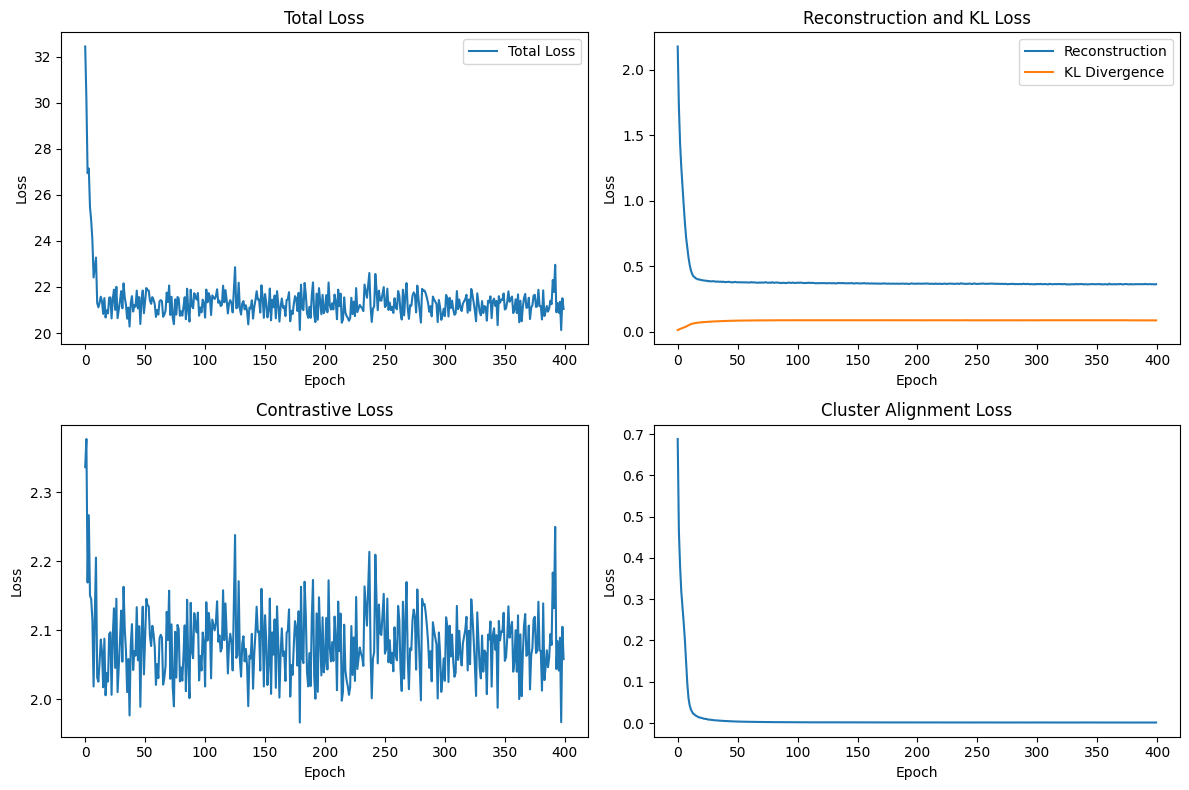

In [9]:
# ---- 5. 訓練結果の可視化 ----
def plot_training_history(history):
    """訓練履歴のプロット"""
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))
    
    axes[0, 0].plot(history['loss'], label='Total Loss')
    axes[0, 0].set_title('Total Loss')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].legend()
    
    axes[0, 1].plot(history['recon_loss'], label='Reconstruction')
    axes[0, 1].plot(history['kl_loss'], label='KL Divergence')
    axes[0, 1].set_title('Reconstruction and KL Loss')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Loss')
    axes[0, 1].legend()
    
    axes[1, 0].plot(history['contrast_loss'], label='Contrastive')
    axes[1, 0].set_title('Contrastive Loss')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Loss')
    
    axes[1, 1].plot(history['align_loss'], label='Alignment')
    axes[1, 1].set_title('Cluster Alignment Loss')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Loss')
    
    plt.tight_layout()
    plt.show()

# 訓練履歴の可視化
plot_training_history(history)

# ---- 6. 潜在表現の取得と可視化 ----
# 訓練済みモデルで潜在表現を取得
wt_latent, wt_labels = trainer.get_latent_representations(wt_loader)
ko_latent, ko_labels = trainer.get_latent_representations(ko_loader)

# numpy配列に変換
wt_latent_np = wt_latent.cpu().numpy()
ko_latent_np = ko_latent.cpu().numpy()
wt_labels_np = wt_labels.cpu().numpy()
ko_labels_np = ko_labels.cpu().numpy()

# UMAPで2次元に投影
import umap
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, random_state=42)

# WTとKOのデータを結合して投影
combined_latent = np.vstack([wt_latent_np, ko_latent_np])
combined_embedding = reducer.fit_transform(combined_latent)

# 投影結果を分割
wt_embedding = combined_embedding[:len(wt_latent_np)]
ko_embedding = combined_embedding[len(wt_latent_np):]

# 細胞タイプの名前リスト
cell_type_names = data_dict['cell_types']


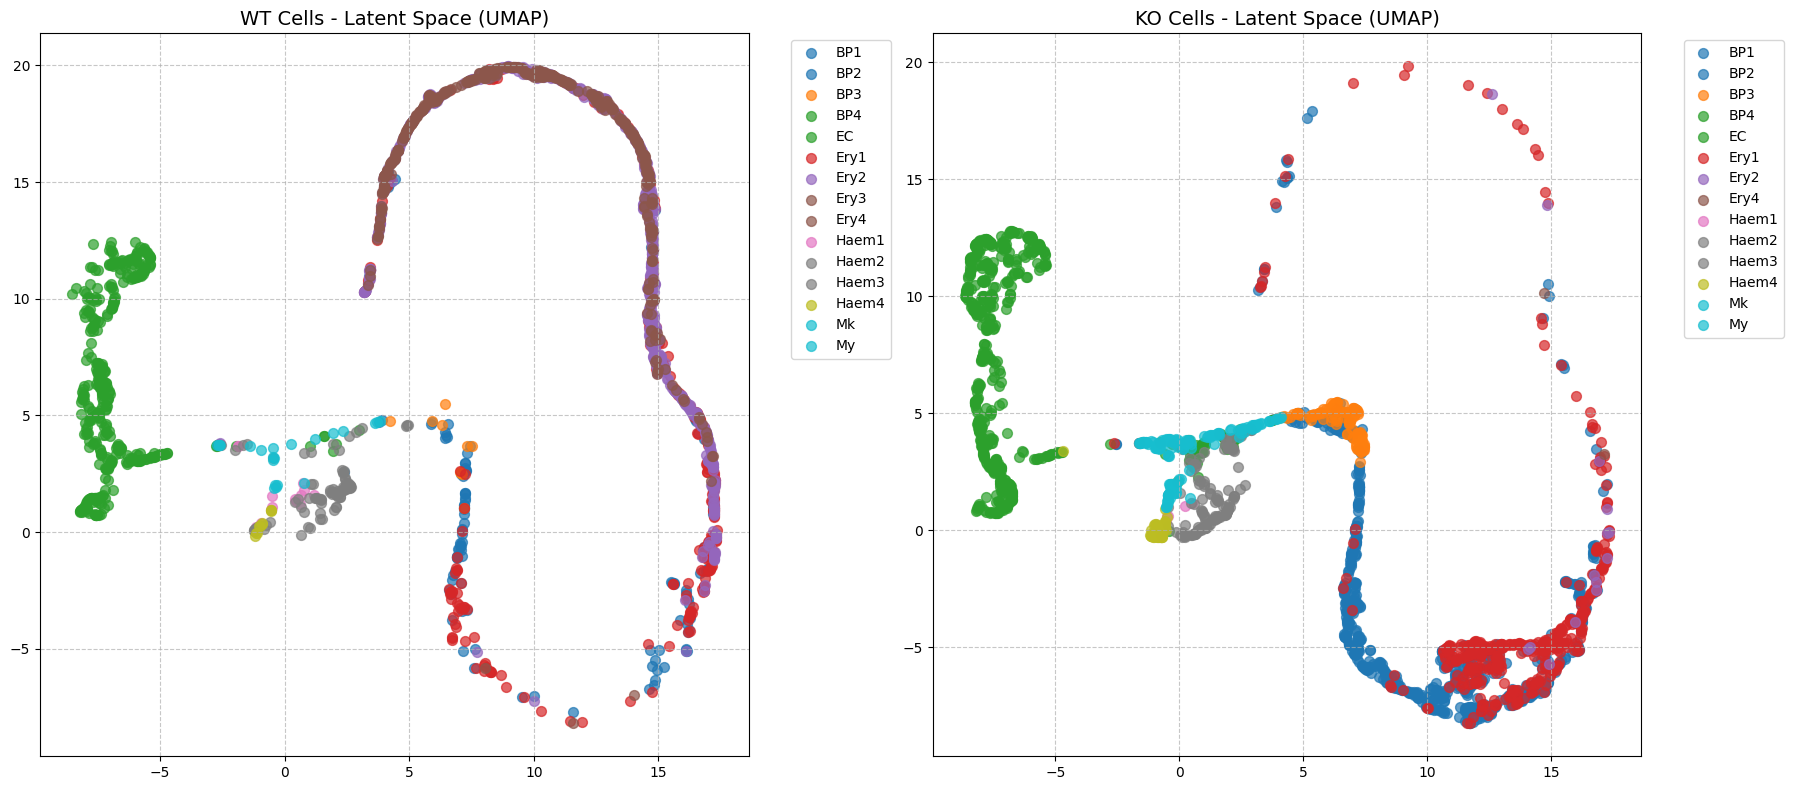

                                 WT   KO
celltype                                
Allantois                         3    1
Blood progenitors 1              53  128
Blood progenitors 2              87  794
Cardiomyocytes                    1    0
Def. endoderm                     1    0
Endothelium                     143  214
Epiblast                          0    1
Erythroid1                      450  745
Erythroid2                      552    4
Erythroid3                      482    2
ExE mesoderm                      1    2
Forebrain/Midbrain/Hindbrain      1    0
Haematoendothelial progenitors  297  372
Intermediate mesoderm             2    2
Mesenchyme                        8    5
Mixed mesoderm                    1    0
Neural crest                      0    1
Paraxial mesoderm                 2    4
Pharyngeal mesoderm               5    6
Rostral neurectoderm              0    1
Surface ectoderm                  1    2


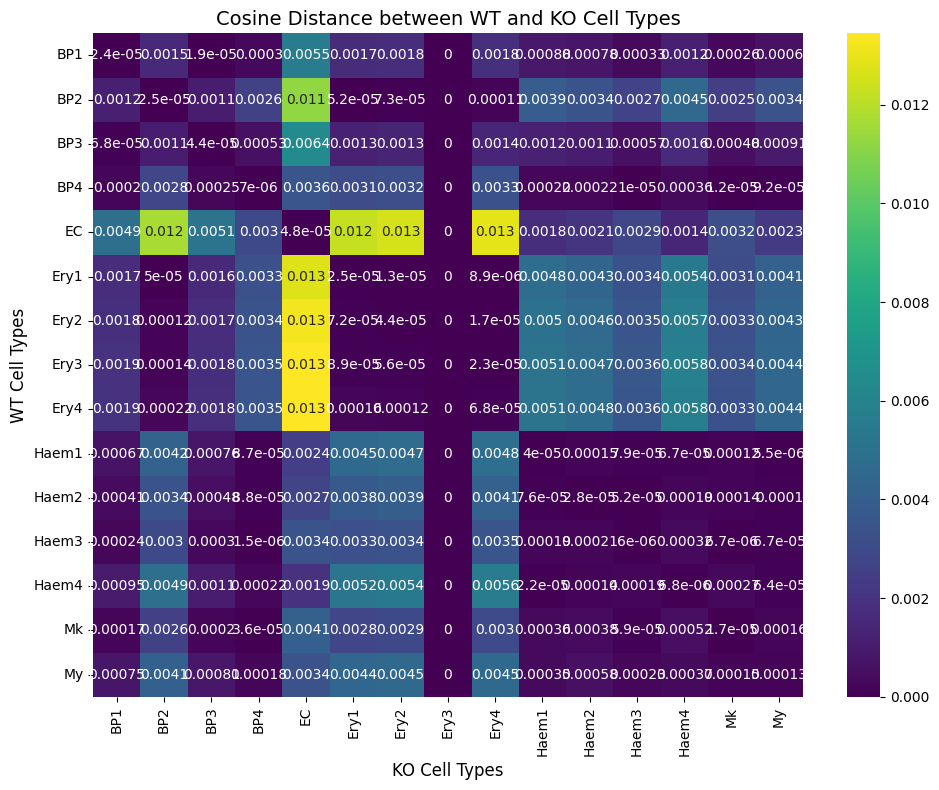

In [10]:
# ---- 7. UMAP可視化 ----
def plot_latent_space(wt_embedding, ko_embedding, wt_labels, ko_labels, cell_type_names):
    """潜在空間の可視化"""
    # カラーマップの設定
    n_cell_types = len(cell_type_names)
    colors = plt.cm.tab10(np.linspace(0, 1, n_cell_types))
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))
    
    # WT細胞の可視化
    for i, ct in enumerate(range(n_cell_types)):
        mask = wt_labels == ct
        if mask.sum() > 0:
            ax1.scatter(
                wt_embedding[mask, 0], 
                wt_embedding[mask, 1],
                c=[colors[i]],
                label=cell_type_names[ct],
                s=50,
                alpha=0.7
            )
    
    ax1.set_title('WT Cells - Latent Space (UMAP)', fontsize=14)
    ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax1.grid(True, linestyle='--', alpha=0.7)
    
    # KO細胞の可視化
    for i, ct in enumerate(range(n_cell_types)):
        mask = ko_labels == ct
        if mask.sum() > 0:
            ax2.scatter(
                ko_embedding[mask, 0], 
                ko_embedding[mask, 1],
                c=[colors[i]],
                label=cell_type_names[ct],
                s=50,
                alpha=0.7
            )
    
    ax2.set_title('KO Cells - Latent Space (UMAP)', fontsize=14)
    ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax2.grid(True, linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    plt.show()

# 潜在空間の可視化
plot_latent_space(wt_embedding, ko_embedding, wt_labels_np, ko_labels_np, cell_type_names)

# 超シンプルな1行コード - テーブルのみ
print(pd.DataFrame({'WT': adata_wt_aligned.obs['celltype'].value_counts(), 
                    'KO': adata_ko_aligned.obs['celltype'].value_counts()}).fillna(0).astype(int))

# ---- 8. WTとKOの細胞タイプ間距離分析 ----
def compute_celltype_distances(wt_latent, ko_latent, wt_labels, ko_labels, n_cell_types):
    """細胞タイプ間の平均コサイン距離を計算"""
    import scipy.spatial.distance as dist
    
    distance_matrix = np.zeros((n_cell_types, n_cell_types))
    
    for wt_ct in range(n_cell_types):
        wt_mask = wt_labels == wt_ct
        if not np.any(wt_mask):
            continue
            
        wt_centroid = wt_latent[wt_mask].mean(axis=0)
        
        for ko_ct in range(n_cell_types):
            ko_mask = ko_labels == ko_ct
            if not np.any(ko_mask):
                continue
                
            ko_centroid = ko_latent[ko_mask].mean(axis=0)
            
            # コサイン距離の計算
            cos_dist = dist.cosine(wt_centroid, ko_centroid)
            distance_matrix[wt_ct, ko_ct] = cos_dist
    
    return distance_matrix

# 細胞タイプ間距離の計算と可視化
n_cell_types = len(data_dict['cell_types'])
distance_matrix = compute_celltype_distances(
    wt_latent_np, ko_latent_np, 
    wt_labels_np, ko_labels_np, 
    n_cell_types
)

# ヒートマップ可視化
plt.figure(figsize=(10, 8))
sns.heatmap(
    distance_matrix,
    annot=True,
    cmap='viridis',
    xticklabels=[data_dict['cell_types'][i] for i in range(n_cell_types)],
    yticklabels=[data_dict['cell_types'][i] for i in range(n_cell_types)]
)
plt.title('Cosine Distance between WT and KO Cell Types', fontsize=14)
plt.xlabel('KO Cell Types', fontsize=12)
plt.ylabel('WT Cell Types', fontsize=12)
plt.tight_layout()
plt.show()

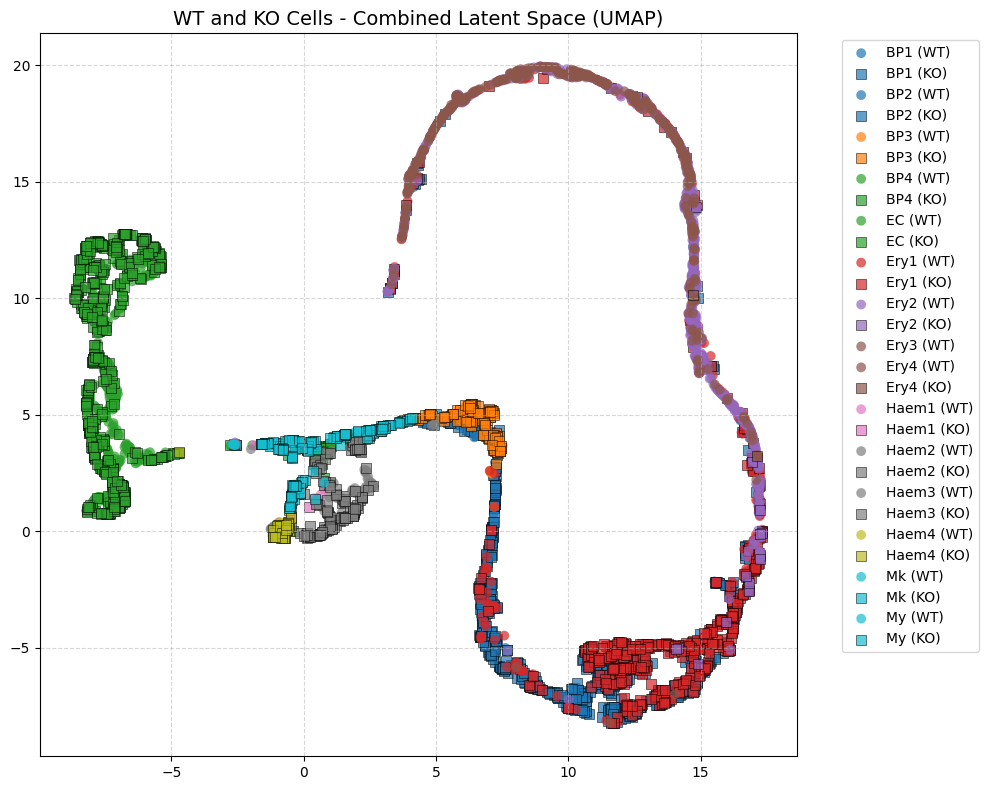

In [12]:
def plot_combined_latent_space(wt_embedding, ko_embedding, wt_labels, ko_labels, cell_type_names):
    """WTとKO細胞を同一空間に可視化（色＝細胞タイプ、マーカー＝WT/KO）"""
    import matplotlib.patches as mpatches
    
    n_cell_types = len(cell_type_names)
    colors = plt.cm.tab10(np.linspace(0, 1, n_cell_types))

    # 結合
    combined_embedding = np.vstack([wt_embedding, ko_embedding])
    combined_labels = np.concatenate([wt_labels, ko_labels])
    combined_group = np.array(['WT'] * len(wt_labels) + ['KO'] * len(ko_labels))
    
    # 描画
    plt.figure(figsize=(10, 8))
    
    for i in range(n_cell_types):
        for group, marker in zip(['WT', 'KO'], ['o', 's']):
            mask = (combined_labels == i) & (combined_group == group)
            if mask.sum() > 0:
                plt.scatter(
                    combined_embedding[mask, 0],
                    combined_embedding[mask, 1],
                    c=[colors[i]],
                    label=f"{cell_type_names[i]} ({group})",
                    s=50,
                    alpha=0.7,
                    marker=marker,
                    edgecolor='k' if group == 'KO' else 'none',
                    linewidths=0.5
                )
    
    plt.title('WT and KO Cells - Combined Latent Space (UMAP)', fontsize=14)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', ncol=1)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

# 使用例：WT/KOを1つのUMAP空間にまとめてプロット
plot_combined_latent_space(
    wt_embedding=wt_embedding ,
    ko_embedding=ko_embedding ,
    wt_labels=wt_labels_np,
    ko_labels=ko_labels_np,
    cell_type_names=data_dict['cell_types']
)


velocity基礎分析

WTのvelocity_pcaを計算中...
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_pca', embedded velocity vectors (adata.obsm)
KOのvelocity_pcaを計算中...
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_pca', embedded velocity vectors (adata.obsm)


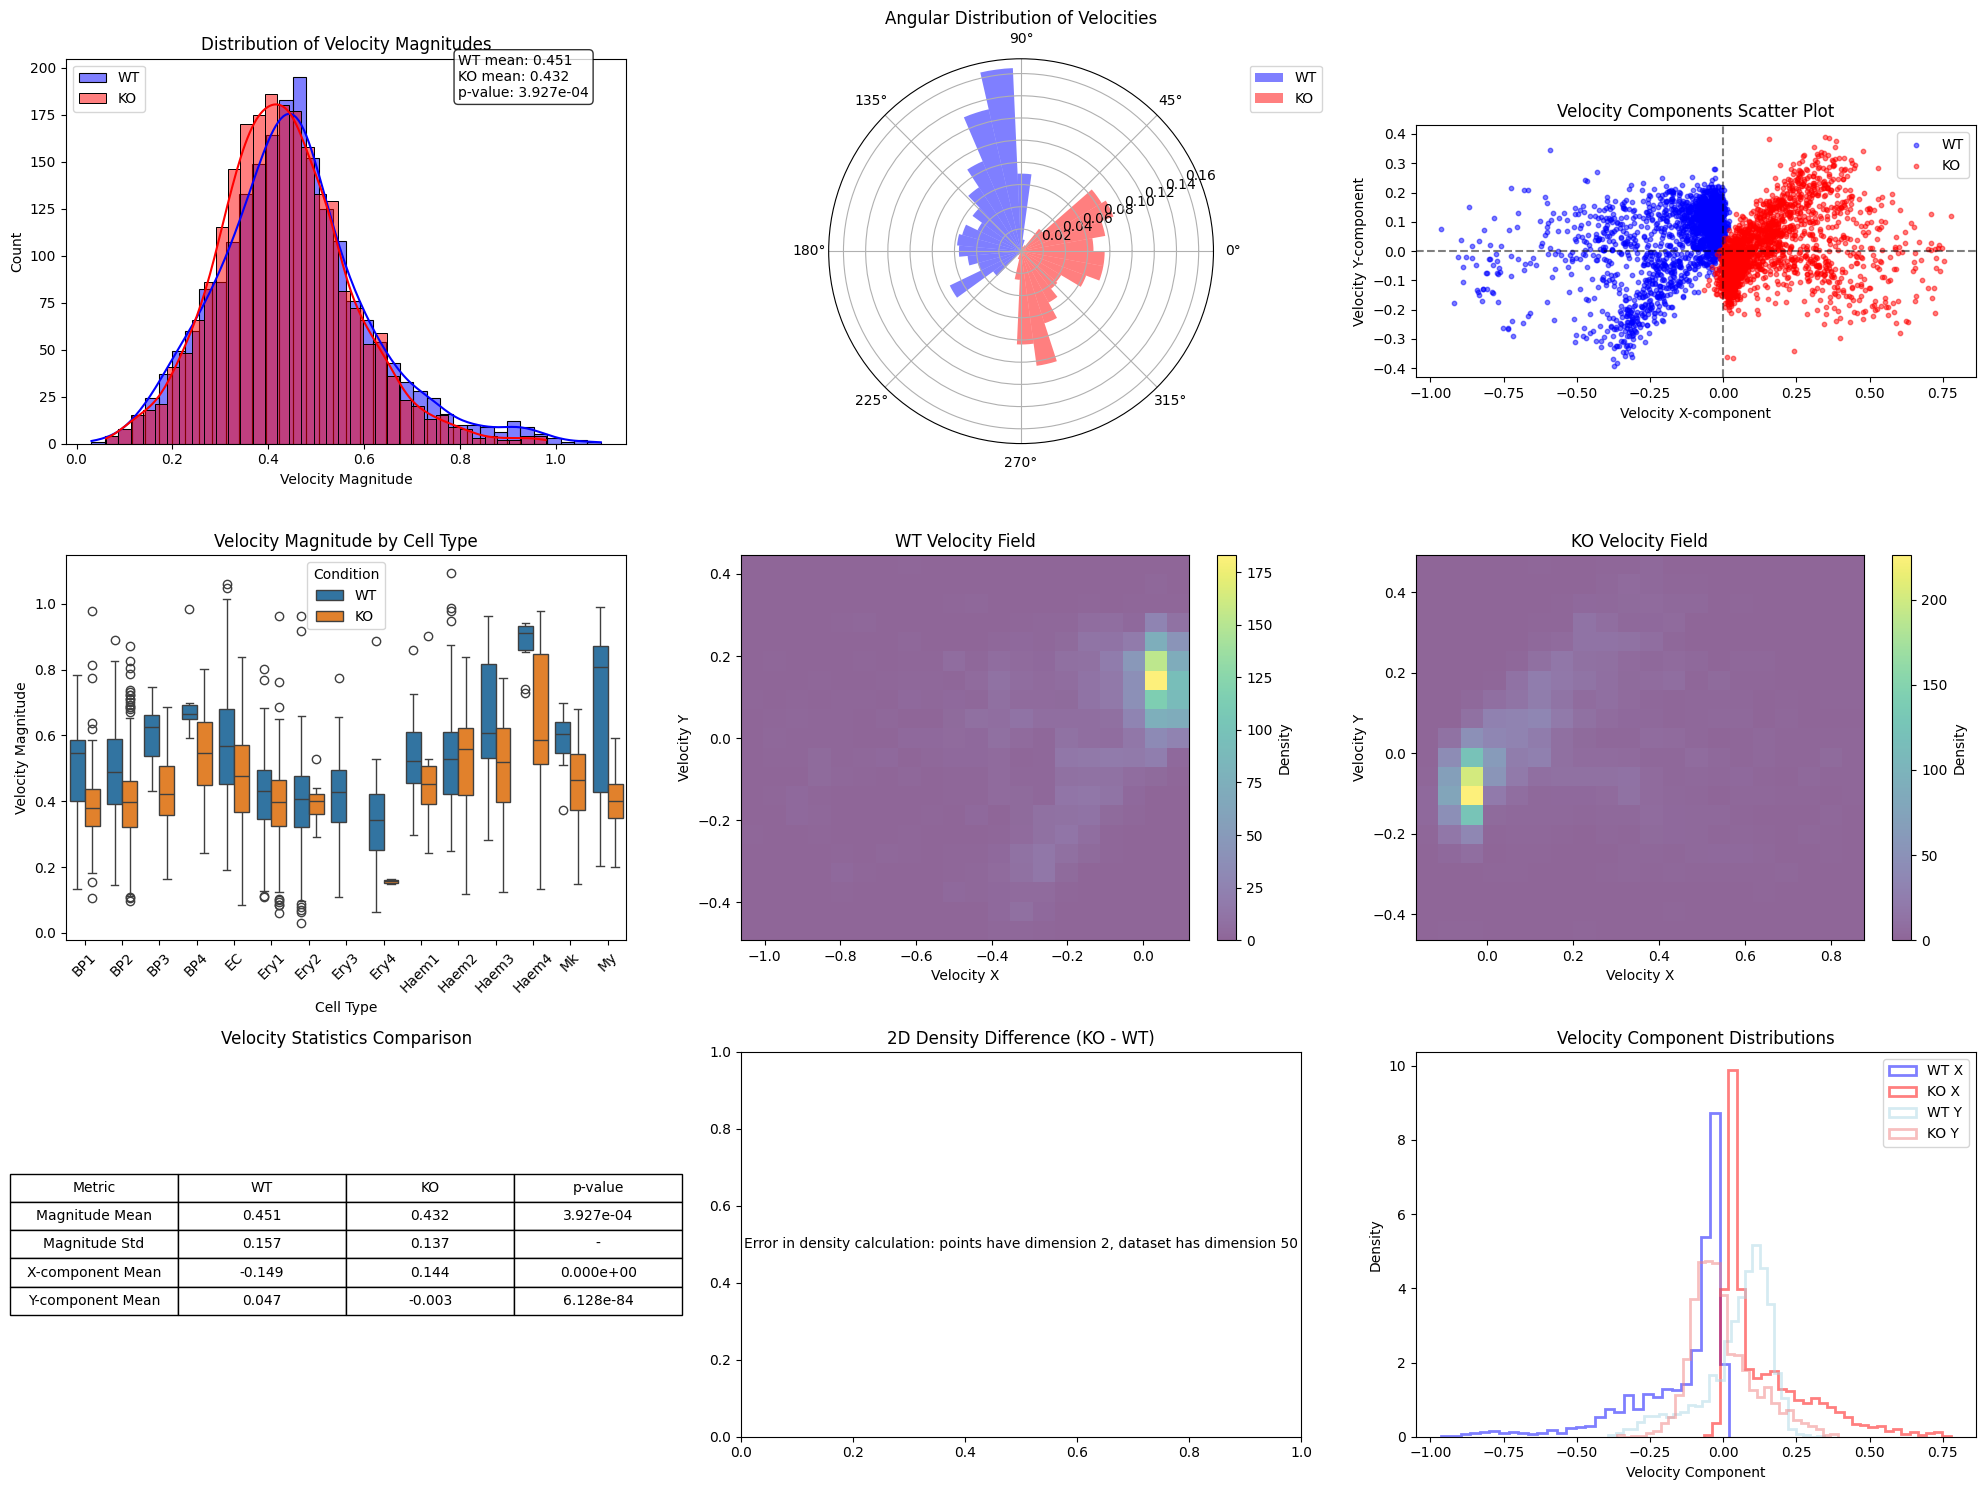

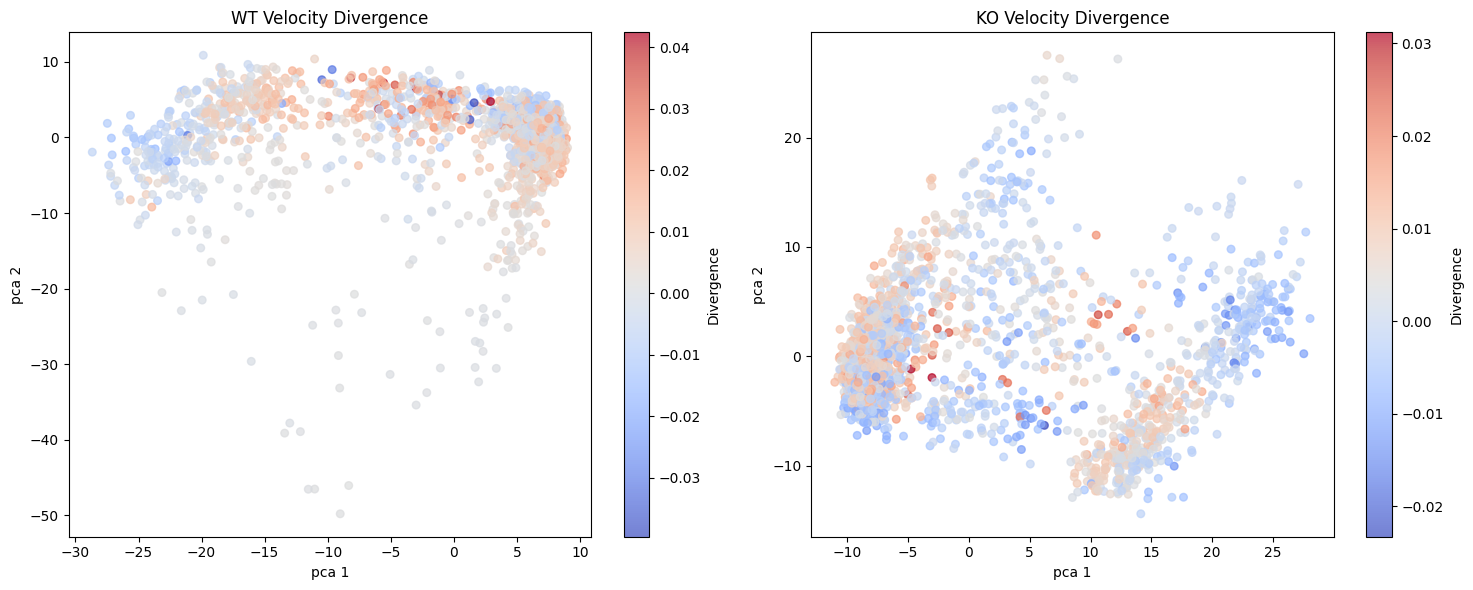

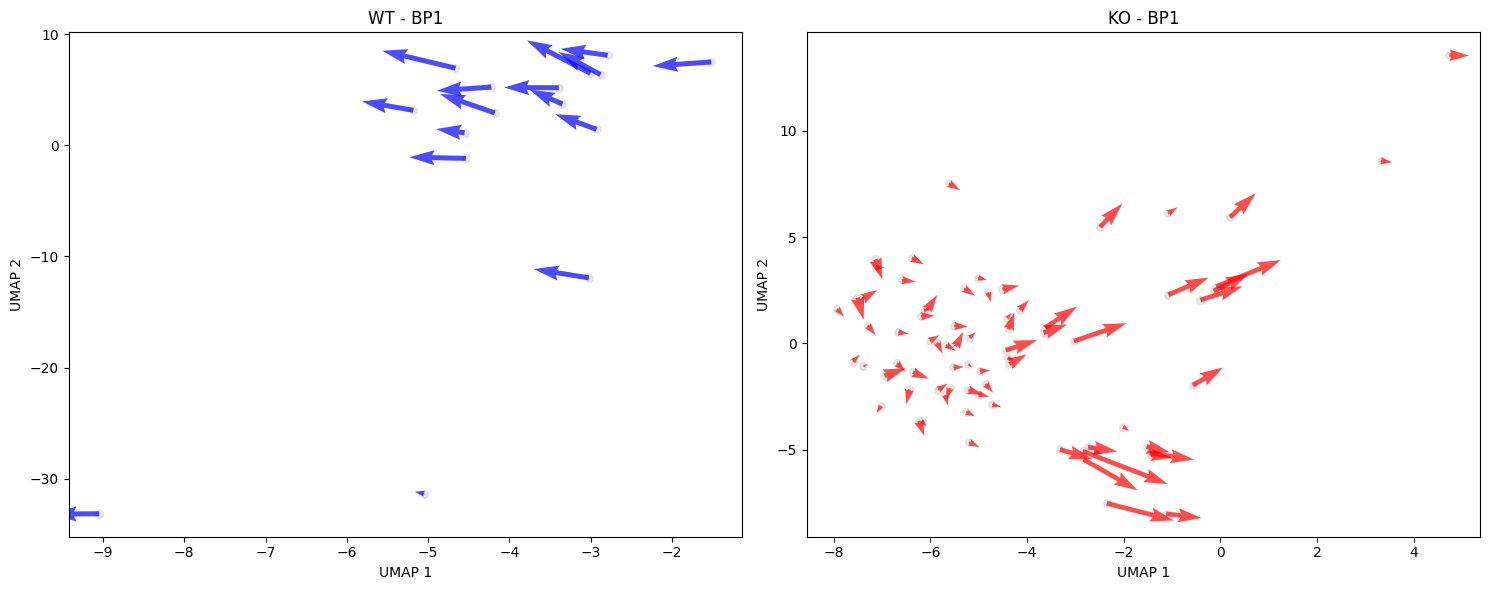


BP1の速度統計:
WT細胞数: 16
KO細胞数: 74
WT平均速度: 0.502
KO平均速度: 0.396
p-value: 2.678e-03


In [13]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy import stats
import scvelo as scv
from matplotlib.patches import FancyArrowPatch
from matplotlib.collections import LineCollection

def analyze_velocity_distributions(adata_wt, adata_ko, basis='umap', cell_type_column='haem_subclust_grouped'):
    """
    WTとKO細胞の速度ベクトル分布を解析
    
    Parameters:
    -----------
    adata_wt, adata_ko: AnnDataオブジェクト
    basis: 埋め込み基底（'umap', 'tsne', 'pca'など）
    cell_type_column: セルタイプを含むカラム名
    """
    
    # velocity_embeddingが計算されているか確認
    vkey = f'velocity_{basis}'
    
    # X_umapが存在するか確認
    if f'X_{basis}' not in adata_wt.obsm:
        print(f"X_{basis}が見つかりません。利用可能な埋め込み: {list(adata_wt.obsm.keys())}")
        return None
    
    try:
        # velocity_embeddingが未計算の場合は計算
        if vkey not in adata_wt.obsm:
            print(f"WTの{vkey}を計算中...")
            scv.tl.velocity_embedding(adata_wt, basis=basis)
        if vkey not in adata_ko.obsm:
            print(f"KOの{vkey}を計算中...")
            scv.tl.velocity_embedding(adata_ko, basis=basis)
    except Exception as e:
        print(f"velocity_embedding計算中にエラー: {e}")
        return None
    
    # 速度ベクトルの取得
    V_wt = adata_wt.obsm[vkey]
    V_ko = adata_ko.obsm[vkey]
    
    # セルタイプラベルの取得
    if cell_type_column in adata_wt.obs:
        wt_labels = adata_wt.obs[cell_type_column].astype(str).values
        ko_labels = adata_ko.obs[cell_type_column].astype(str).values
        # セルタイプ名のリスト
        cell_type_names = sorted(set(wt_labels.tolist() + ko_labels.tolist()))
        # ラベルを数値に変換
        label_to_idx = {label: idx for idx, label in enumerate(cell_type_names)}
        wt_labels_numeric = np.array([label_to_idx[label] for label in wt_labels])
        ko_labels_numeric = np.array([label_to_idx[label] for label in ko_labels])
    else:
        print(f"警告: {cell_type_column}が見つかりません")
        wt_labels = np.zeros(len(V_wt))
        ko_labels = np.zeros(len(V_ko))
        wt_labels_numeric = wt_labels
        ko_labels_numeric = ko_labels
        cell_type_names = ['Unknown']
    
    # 分析結果を返す
    results = {
        'V_wt': V_wt,
        'V_ko': V_ko,
        'wt_labels': wt_labels,
        'ko_labels': ko_labels,
        'wt_labels_numeric': wt_labels_numeric,
        'ko_labels_numeric': ko_labels_numeric,
        'cell_type_names': cell_type_names,
        'X_wt': adata_wt.obsm[f'X_{basis}'],
        'X_ko': adata_ko.obsm[f'X_{basis}']
    }
    
    # 可視化
    plot_velocity_distributions(V_wt, V_ko, wt_labels_numeric, ko_labels_numeric, cell_type_names)
    
    return results

def plot_velocity_distributions(V_wt, V_ko, wt_labels, ko_labels, cell_type_names=None):
    """速度ベクトルの分布を可視化"""
    
    fig = plt.figure(figsize=(20, 15))
    
    # 1. 速度ベクトルの大きさの分布
    ax1 = plt.subplot(3, 3, 1)
    plot_velocity_magnitude_distribution(V_wt, V_ko, ax1)
    
    # 2. 速度ベクトルの角度分布
    ax2 = plt.subplot(3, 3, 2, projection='polar')
    plot_velocity_angle_distribution(V_wt, V_ko, ax2)
    
    # 3. 速度成分の散布図
    ax3 = plt.subplot(3, 3, 3)
    plot_velocity_component_scatter(V_wt, V_ko, ax3)
    
    # 4. セルタイプ別の速度大きさ
    ax4 = plt.subplot(3, 3, 4)
    plot_velocity_by_celltype(V_wt, V_ko, wt_labels, ko_labels, cell_type_names, ax4)
    
    # 5. 速度ベクトル場の可視化
    ax5 = plt.subplot(3, 3, 5)
    plot_velocity_field(V_wt, 'WT', ax5)
    
    ax6 = plt.subplot(3, 3, 6)
    plot_velocity_field(V_ko, 'KO', ax6)
    
    # 6. 速度の統計的比較
    ax7 = plt.subplot(3, 3, 7)
    plot_velocity_statistics(V_wt, V_ko, ax7)
    
    # 7. 速度の2D密度プロット
    ax8 = plt.subplot(3, 3, 8)
    plot_velocity_2d_density(V_wt, V_ko, ax8)
    
    # 8. 速度コンポーネントのヒストグラム
    ax9 = plt.subplot(3, 3, 9)
    plot_velocity_component_histograms(V_wt, V_ko, ax9)
    
    plt.tight_layout()
    plt.show()

def plot_velocity_magnitude_distribution(V_wt, V_ko, ax):
    """速度ベクトルの大きさの分布を比較"""
    # 速度の大きさを計算
    magnitude_wt = np.linalg.norm(V_wt, axis=1)
    magnitude_ko = np.linalg.norm(V_ko, axis=1)
    
    # ヒストグラムとKDE
    sns.histplot(magnitude_wt, kde=True, alpha=0.5, label='WT', color='blue', ax=ax)
    sns.histplot(magnitude_ko, kde=True, alpha=0.5, label='KO', color='red', ax=ax)
    
    ax.set_xlabel('Velocity Magnitude')
    ax.set_ylabel('Count')
    ax.set_title('Distribution of Velocity Magnitudes')
    ax.legend()
    
    # 統計情報を追加
    stats_text = f'WT mean: {np.mean(magnitude_wt):.3f}\n'
    stats_text += f'KO mean: {np.mean(magnitude_ko):.3f}\n'
    stats_text += f'p-value: {stats.mannwhitneyu(magnitude_wt, magnitude_ko).pvalue:.3e}'
    ax.text(0.7, 0.9, stats_text, transform=ax.transAxes, 
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

def plot_velocity_angle_distribution(V_wt, V_ko, ax):
    """速度ベクトルの角度分布を極座標で表示"""
    # 角度を計算
    angles_wt = np.arctan2(V_wt[:, 1], V_wt[:, 0])
    angles_ko = np.arctan2(V_ko[:, 1], V_ko[:, 0])
    
    # 極座標ヒストグラム
    bins = np.linspace(-np.pi, np.pi, 36)
    
    # WT
    counts_wt, bins = np.histogram(angles_wt, bins=bins)
    counts_wt = counts_wt / counts_wt.sum()  # 正規化
    width = bins[1] - bins[0]
    ax.bar(bins[:-1], counts_wt, width=width, alpha=0.5, 
           label='WT', color='blue', bottom=0.0)
    
    # KO
    counts_ko, _ = np.histogram(angles_ko, bins=bins)
    counts_ko = counts_ko / counts_ko.sum()  # 正規化
    ax.bar(bins[:-1], counts_ko, width=width, alpha=0.5, 
           label='KO', color='red', bottom=0.0)
    
    ax.set_title('Angular Distribution of Velocities')
    ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0))
    ax.set_theta_zero_location('E')
    ax.set_theta_direction(1)

def plot_velocity_component_scatter(V_wt, V_ko, ax):
    """速度成分の散布図"""
    # 散布図
    ax.scatter(V_wt[:, 0], V_wt[:, 1], alpha=0.5, s=10, 
               label='WT', color='blue')
    ax.scatter(V_ko[:, 0], V_ko[:, 1], alpha=0.5, s=10, 
               label='KO', color='red')
    
    ax.set_xlabel('Velocity X-component')
    ax.set_ylabel('Velocity Y-component')
    ax.set_title('Velocity Components Scatter Plot')
    ax.legend()
    ax.axhline(y=0, color='k', linestyle='--', alpha=0.5)
    ax.axvline(x=0, color='k', linestyle='--', alpha=0.5)
    ax.set_aspect('equal')

def plot_velocity_by_celltype(V_wt, V_ko, wt_labels, ko_labels, cell_type_names, ax):
    """セルタイプ別の速度大きさ"""
    # 速度の大きさを計算
    magnitude_wt = np.linalg.norm(V_wt, axis=1)
    magnitude_ko = np.linalg.norm(V_ko, axis=1)
    
    # データフレームを作成
    df_list = []
    
    unique_wt_labels = np.unique(wt_labels)
    unique_ko_labels = np.unique(ko_labels)
    
    for ct in unique_wt_labels:
        mask = wt_labels == ct
        if np.sum(mask) > 0:
            df_list.extend([
                {'Condition': 'WT', 
                 'Cell Type': cell_type_names[int(ct)] if cell_type_names and int(ct) < len(cell_type_names) else f'Type {ct}',
                 'Velocity Magnitude': mag}
                for mag in magnitude_wt[mask]
            ])
    
    for ct in unique_ko_labels:
        mask = ko_labels == ct
        if np.sum(mask) > 0:
            df_list.extend([
                {'Condition': 'KO', 
                 'Cell Type': cell_type_names[int(ct)] if cell_type_names and int(ct) < len(cell_type_names) else f'Type {ct}',
                 'Velocity Magnitude': mag}
                for mag in magnitude_ko[mask]
            ])
    
    if df_list:
        df = pd.DataFrame(df_list)
        
        # ボックスプロット
        sns.boxplot(data=df, x='Cell Type', y='Velocity Magnitude', 
                    hue='Condition', ax=ax)
        ax.set_title('Velocity Magnitude by Cell Type')
        ax.tick_params(axis='x', rotation=45)
    else:
        ax.text(0.5, 0.5, 'No data to display', ha='center', va='center', transform=ax.transAxes)
        ax.set_title('Velocity Magnitude by Cell Type')

def plot_velocity_field(V, title, ax):
    """速度ベクトル場の可視化"""
    if len(V) == 0:
        ax.text(0.5, 0.5, 'No velocity data', ha='center', va='center', transform=ax.transAxes)
        ax.set_title(f'{title} Velocity Field')
        return
    
    # グリッドポイントを生成
    x_min, x_max = V[:, 0].min() - 0.1, V[:, 0].max() + 0.1
    y_min, y_max = V[:, 1].min() - 0.1, V[:, 1].max() + 0.1
    
    # 2Dヒストグラムで密度を計算
    H, xedges, yedges = np.histogram2d(V[:, 0], V[:, 1], bins=20)
    
    # 密度プロット
    im = ax.imshow(H.T, origin='lower', aspect='auto',
                   extent=[x_min, x_max, y_min, y_max],
                   cmap='viridis', alpha=0.6)
    
    # カラーバー
    plt.colorbar(im, ax=ax, label='Density')
    
    ax.set_xlabel('Velocity X')
    ax.set_ylabel('Velocity Y')
    ax.set_title(f'{title} Velocity Field')
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)

def plot_velocity_statistics(V_wt, V_ko, ax):
    """速度の統計的比較"""
    # 統計量の計算
    stats_data = []
    
    # 大きさ
    mag_wt = np.linalg.norm(V_wt, axis=1)
    mag_ko = np.linalg.norm(V_ko, axis=1)
    
    # p値の計算（安全に）
    try:
        mag_pval = stats.mannwhitneyu(mag_wt, mag_ko).pvalue
    except:
        mag_pval = np.nan
    
    stats_data.append({
        'Metric': 'Magnitude Mean',
        'WT': np.mean(mag_wt),
        'KO': np.mean(mag_ko),
        'p-value': mag_pval
    })
    
    stats_data.append({
        'Metric': 'Magnitude Std',
        'WT': np.std(mag_wt),
        'KO': np.std(mag_ko),
        'p-value': np.nan
    })
    
    # X成分
    try:
        x_pval = stats.mannwhitneyu(V_wt[:, 0], V_ko[:, 0]).pvalue
    except:
        x_pval = np.nan
        
    stats_data.append({
        'Metric': 'X-component Mean',
        'WT': np.mean(V_wt[:, 0]),
        'KO': np.mean(V_ko[:, 0]),
        'p-value': x_pval
    })
    
    # Y成分
    try:
        y_pval = stats.mannwhitneyu(V_wt[:, 1], V_ko[:, 1]).pvalue
    except:
        y_pval = np.nan
        
    stats_data.append({
        'Metric': 'Y-component Mean',
        'WT': np.mean(V_wt[:, 1]),
        'KO': np.mean(V_ko[:, 1]),
        'p-value': y_pval
    })
    
    # データフレーム作成
    df_stats = pd.DataFrame(stats_data)
    
    # 表として表示
    ax.axis('tight')
    ax.axis('off')
    
    # 表のフォーマット
    formatted_df = df_stats.copy()
    for col in ['WT', 'KO']:
        formatted_df[col] = formatted_df[col].apply(lambda x: f'{x:.3f}')
    formatted_df['p-value'] = formatted_df['p-value'].apply(
        lambda x: f'{x:.3e}' if not np.isnan(x) else '-'
    )
    
    table = ax.table(cellText=formatted_df.values,
                    colLabels=formatted_df.columns,
                    cellLoc='center',
                    loc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1.2, 1.5)
    ax.set_title('Velocity Statistics Comparison')

def plot_velocity_2d_density(V_wt, V_ko, ax):
    """速度の2D密度プロット"""
    from scipy.stats import gaussian_kde
    
    try:
        # KDE推定
        kde_wt = gaussian_kde(V_wt.T)
        kde_ko = gaussian_kde(V_ko.T)
        
        # グリッド生成
        x_min = min(V_wt[:, 0].min(), V_ko[:, 0].min()) - 0.1
        x_max = max(V_wt[:, 0].max(), V_ko[:, 0].max()) + 0.1
        y_min = min(V_wt[:, 1].min(), V_ko[:, 1].min()) - 0.1
        y_max = max(V_wt[:, 1].max(), V_ko[:, 1].max()) + 0.1
        
        xx, yy = np.mgrid[x_min:x_max:100j, y_min:y_max:100j]
        positions = np.vstack([xx.ravel(), yy.ravel()])
        
        # 密度計算
        density_wt = kde_wt(positions).reshape(xx.shape)
        density_ko = kde_ko(positions).reshape(xx.shape)
        
        # 密度差
        density_diff = density_ko - density_wt
        
        # プロット
        im = ax.contourf(xx, yy, density_diff, levels=20, 
                         cmap='RdBu_r', alpha=0.8)
        plt.colorbar(im, ax=ax, label='Density (KO - WT)')
        
        ax.set_xlabel('Velocity X')
        ax.set_ylabel('Velocity Y')
        ax.set_title('2D Density Difference (KO - WT)')
        ax.set_aspect('equal')
    except Exception as e:
        ax.text(0.5, 0.5, f'Error in density calculation: {str(e)}', 
                ha='center', va='center', transform=ax.transAxes)
        ax.set_title('2D Density Difference (KO - WT)')

def plot_velocity_component_histograms(V_wt, V_ko, ax):
    """速度成分のヒストグラム"""
    # 各成分のヒストグラム
    bins = 30
    
    # X成分
    ax.hist(V_wt[:, 0], bins=bins, alpha=0.5, label='WT X', 
            color='blue', density=True, histtype='step', linewidth=2)
    ax.hist(V_ko[:, 0], bins=bins, alpha=0.5, label='KO X', 
            color='red', density=True, histtype='step', linewidth=2)
    
    # Y成分
    ax.hist(V_wt[:, 1], bins=bins, alpha=0.5, label='WT Y', 
            color='lightblue', density=True, histtype='step', linewidth=2)
    ax.hist(V_ko[:, 1], bins=bins, alpha=0.5, label='KO Y', 
            color='lightcoral', density=True, histtype='step', linewidth=2)
    
    ax.set_xlabel('Velocity Component')
    ax.set_ylabel('Density')
    ax.set_title('Velocity Component Distributions')
    ax.legend()

# 使用例
# results = analyze_velocity_distributions(adata_wt_aligned, adata_ko_aligned, 
#                                        basis='umap', 
#                                        cell_type_column='haem_subclust_grouped')

# さらに詳細な解析用の関数
def calculate_velocity_divergence(V, X, n_neighbors=30):
    """速度場の発散を計算"""
    from sklearn.neighbors import NearestNeighbors
    
    # 近傍を見つける
    nbrs = NearestNeighbors(n_neighbors=n_neighbors).fit(X)
    distances, indices = nbrs.kneighbors(X)
    
    divergence = np.zeros(len(X))
    
    for i in range(len(X)):
        # 近傍の速度ベクトル
        neighbor_indices = indices[i, 1:]  # 自分自身を除く
        neighbor_positions = X[neighbor_indices]
        neighbor_velocities = V[neighbor_indices]
        
        # 有限差分で発散を近似
        dx = neighbor_positions - X[i]
        dv = neighbor_velocities - V[i]
        
        # 各方向での変化率を計算
        div = 0
        for j in range(len(neighbor_indices)):
            if np.linalg.norm(dx[j]) > 0:
                div += np.dot(dv[j], dx[j]) / (np.linalg.norm(dx[j])**2)
        
        divergence[i] = div / len(neighbor_indices)
    
    return divergence

def compare_velocity_patterns(adata_wt, adata_ko, basis='umap'):
    """WTとKOの速度パターンを詳細に比較"""
    # 速度と位置を取得
    V_wt = adata_wt.obsm[f'velocity_{basis}']
    V_ko = adata_ko.obsm[f'velocity_{basis}']
    X_wt = adata_wt.obsm[f'X_{basis}']
    X_ko = adata_ko.obsm[f'X_{basis}']
    
    # 発散を計算
    div_wt = calculate_velocity_divergence(V_wt, X_wt)
    div_ko = calculate_velocity_divergence(V_ko, X_ko)
    
    # プロット
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
    # WT
    scatter = axes[0].scatter(X_wt[:, 0], X_wt[:, 1], c=div_wt, 
                             cmap='coolwarm', s=30, alpha=0.7)
    plt.colorbar(scatter, ax=axes[0], label='Divergence')
    axes[0].set_title('WT Velocity Divergence')
    axes[0].set_xlabel(f'{basis} 1')
    axes[0].set_ylabel(f'{basis} 2')
    
    # KO
    scatter = axes[1].scatter(X_ko[:, 0], X_ko[:, 1], c=div_ko, 
                             cmap='coolwarm', s=30, alpha=0.7)
    plt.colorbar(scatter, ax=axes[1], label='Divergence')
    axes[1].set_title('KO Velocity Divergence')
    axes[1].set_xlabel(f'{basis} 1')
    axes[1].set_ylabel(f'{basis} 2')
    
    plt.tight_layout()
    plt.show()
    
    return div_wt, div_ko

# セルタイプ特異的な速度解析
def analyze_celltype_specific_velocities(results, cell_type_name):
    """特定のセルタイプに限定した速度解析"""
    # 特定のセルタイプのインデックスを取得
    ct_idx = results['cell_type_names'].index(cell_type_name)
    
    # WTとKOで該当セルタイプをフィルタ
    wt_mask = results['wt_labels_numeric'] == ct_idx
    ko_mask = results['ko_labels_numeric'] == ct_idx
    
    V_wt_ct = results['V_wt'][wt_mask]
    V_ko_ct = results['V_ko'][ko_mask]
    X_wt_ct = results['X_wt'][wt_mask]
    X_ko_ct = results['X_ko'][ko_mask]
    
    # 可視化
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
    # WT
    axes[0].scatter(X_wt_ct[:, 0], X_wt_ct[:, 1], c='lightgray', s=30, alpha=0.5)
    axes[0].quiver(X_wt_ct[:, 0], X_wt_ct[:, 1], 
                   V_wt_ct[:, 0], V_wt_ct[:, 1], 
                   color='blue', alpha=0.7, scale=5)
    axes[0].set_title(f'WT - {cell_type_name}')
    axes[0].set_xlabel('UMAP 1')
    axes[0].set_ylabel('UMAP 2')
    
    # KO
    axes[1].scatter(X_ko_ct[:, 0], X_ko_ct[:, 1], c='lightgray', s=30, alpha=0.5)
    axes[1].quiver(X_ko_ct[:, 0], X_ko_ct[:, 1], 
                   V_ko_ct[:, 0], V_ko_ct[:, 1], 
                   color='red', alpha=0.7, scale=5)
    axes[1].set_title(f'KO - {cell_type_name}')
    axes[1].set_xlabel('UMAP 1')
    axes[1].set_ylabel('UMAP 2')
    
    plt.tight_layout()
    plt.show()
    
    # 統計情報
    mag_wt = np.linalg.norm(V_wt_ct, axis=1)
    mag_ko = np.linalg.norm(V_ko_ct, axis=1)
    
    print(f"\n{cell_type_name}の速度統計:")
    print(f"WT細胞数: {len(V_wt_ct)}")
    print(f"KO細胞数: {len(V_ko_ct)}")
    print(f"WT平均速度: {np.mean(mag_wt):.3f}")
    print(f"KO平均速度: {np.mean(mag_ko):.3f}")
    
    if len(mag_wt) > 1 and len(mag_ko) > 1:
        p_value = stats.mannwhitneyu(mag_wt, mag_ko).pvalue
        print(f"p-value: {p_value:.3e}")
    
    return V_wt_ct, V_ko_ct, X_wt_ct, X_ko_ct

# 基本的な速度分布解析
results = analyze_velocity_distributions(
    adata_wt_aligned, 
    adata_ko_aligned, 
    basis='pca', 
    cell_type_column='haem_subclust_grouped'
)

# 結果が正常に返された場合
if results:
    # 速度パターンの比較
    div_wt, div_ko = compare_velocity_patterns(
        adata_wt_aligned, 
        adata_ko_aligned, 
        basis='pca'
    )
    
    # 特定のセルタイプ（例：BP1）の詳細解析
    cell_type_to_analyze = 'BP1'
    if cell_type_to_analyze in results['cell_type_names']:
        V_wt_ct, V_ko_ct, X_wt_ct, X_ko_ct = analyze_celltype_specific_velocities(
            results, 
            cell_type_to_analyze
        )

ベクトル場　デフォルト

WTのvelocity streamlineを描画中...
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)
KOのvelocity streamlineを描画中...
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


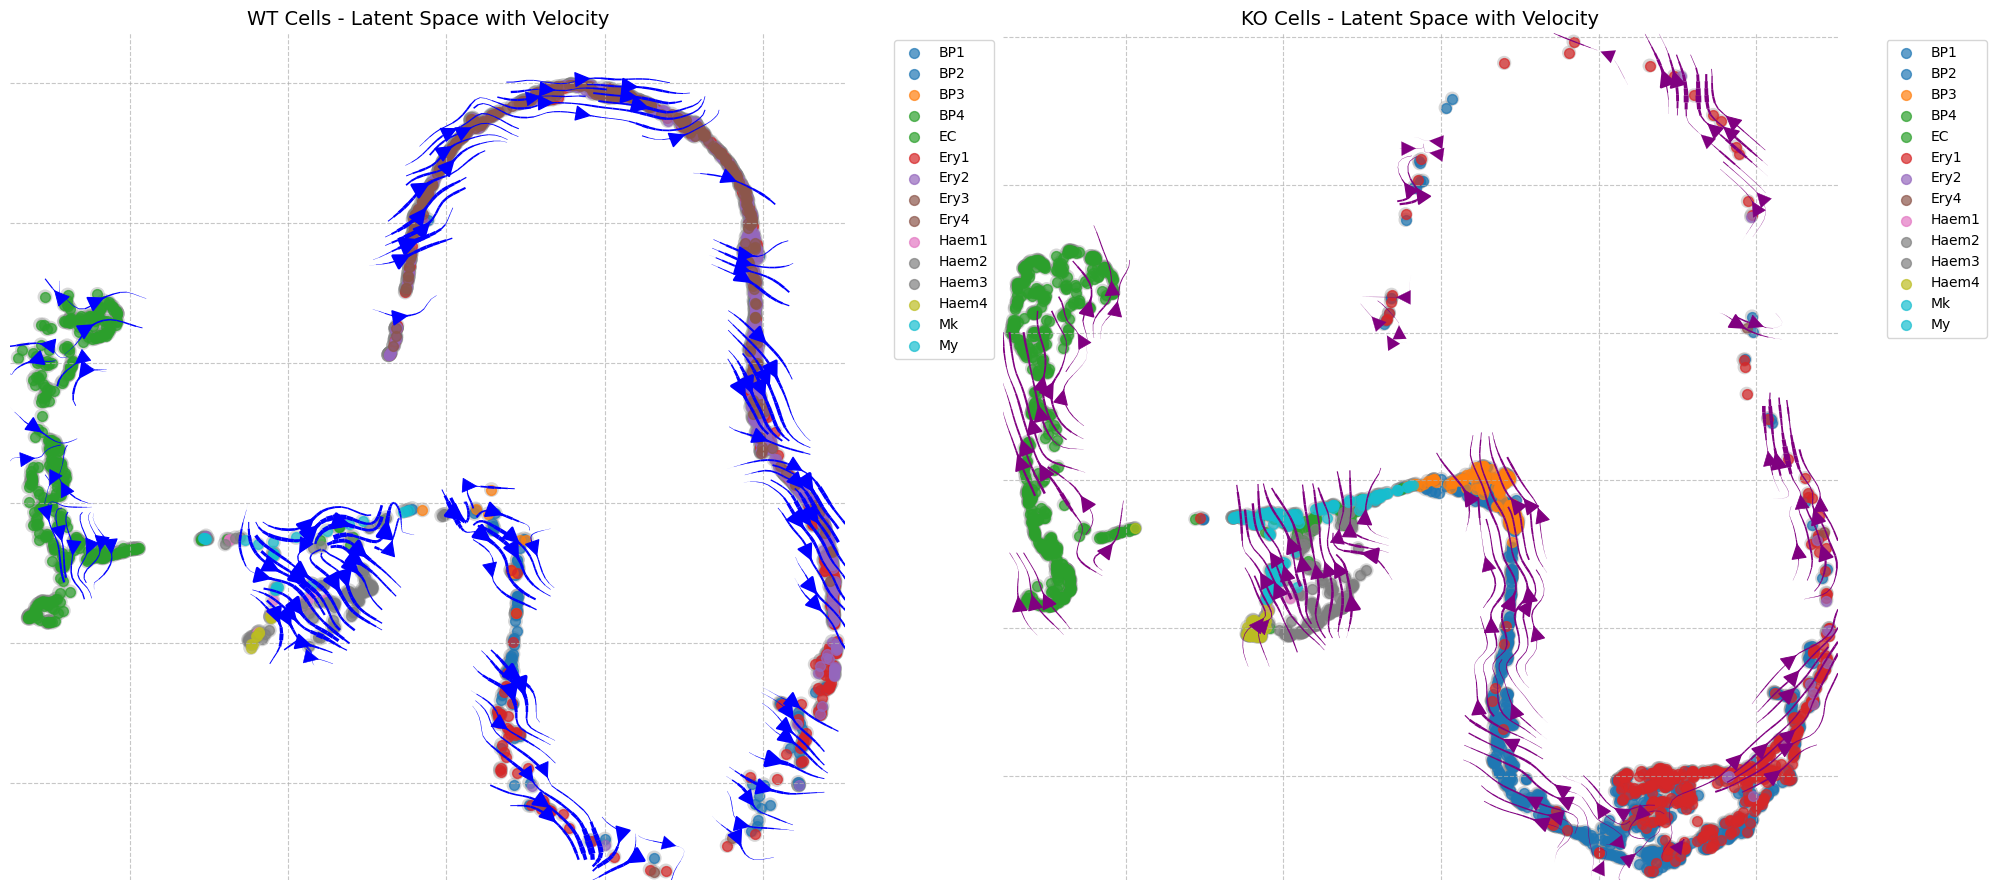

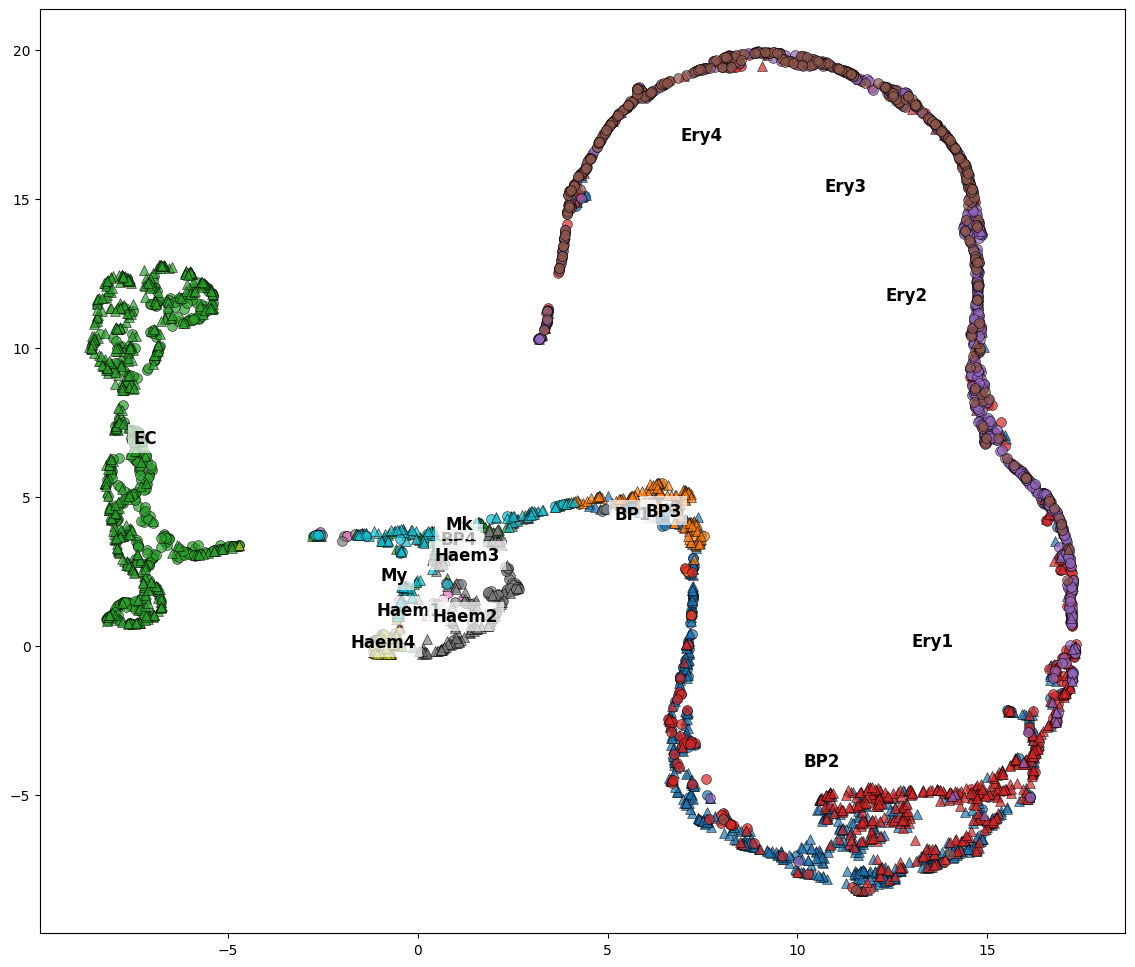

In [14]:
def plot_latent_space_with_velocity(
    wt_embedding, ko_embedding, wt_labels, ko_labels, cell_type_names,
    adata_wt, adata_ko, latent_wt=None, latent_ko=None
):
    """
    潜在空間の可視化にvelocity streamlineを追加
    
    Parameters:
    -----------
    wt_embedding, ko_embedding: UMAP座標
    wt_labels, ko_labels: セルタイプラベル
    cell_type_names: セルタイプ名リスト
    adata_wt, adata_ko: velocityが含まれるAnnDataオブジェクト
    latent_wt, latent_ko: 潜在表現（オプション）
    """
    import matplotlib.pyplot as plt
    import numpy as np
    import scvelo as scv
    
    # カラーマップの設定
    n_cell_types = len(cell_type_names)
    colors = plt.cm.tab10(np.linspace(0, 1, n_cell_types))
    
    # 潜在空間の座標をadataに設定
    adata_wt_copy = adata_wt.copy()
    adata_ko_copy = adata_ko.copy()
    
    # UMAPの座標を更新
    adata_wt_copy.obsm['X_umap'] = wt_embedding
    adata_ko_copy.obsm['X_umap'] = ko_embedding
    
    # 潜在表現が提供された場合は設定
    if latent_wt is not None and latent_ko is not None:
        adata_wt_copy.obsm['X_latent'] = latent_wt
        adata_ko_copy.obsm['X_latent'] = latent_ko
    
    # 可視化
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 9))
    
    # WT細胞の可視化
    for i, ct in enumerate(range(n_cell_types)):
        mask = wt_labels == ct
        if np.sum(mask) > 0:
            ax1.scatter(
                wt_embedding[mask, 0], 
                wt_embedding[mask, 1],
                c=[colors[i]],
                label=cell_type_names[ct],
                s=50,
                alpha=0.7
            )
    
    # velocity graphが存在するか確認
    velocity_graph_exists = 'velocity_graph' in adata_wt_copy.uns
    
    # WT velocity streamline
    if 'velocity' in adata_wt_copy.layers and velocity_graph_exists:
        print("WTのvelocity streamlineを描画中...")
        try:
            # velocity graphが存在しない場合は計算
            if 'velocity_graph' not in adata_wt_copy.uns:
                scv.tl.velocity_graph(adata_wt_copy)
            
            # embedding streamの描画位置を指定
            old_ax = plt.gca()
            plt.sca(ax1)
            
            # streamlineを描画
            scv.pl.velocity_embedding_stream(
                adata_wt_copy, 
                basis='umap',
                color=None,
                linewidth=2.5,
                density=4.0,
                arrow_size=2.5,
                arrow_color='blue',
                show=False,
                title="",
                max_length=8,
                ax=ax1
            )
            plt.sca(old_ax)  # 元の軸に戻す
        except Exception as e:
            print(f"WT velocity streamline描画中にエラー: {e}")
    else:
        print("WT velocity データが見つからないかvelocity_graphがありません")
    
    ax1.set_title('WT Cells - Latent Space with Velocity', fontsize=14)
    ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax1.grid(True, linestyle='--', alpha=0.7)
    
    # KO細胞の可視化
    for i, ct in enumerate(range(n_cell_types)):
        mask = ko_labels == ct
        if np.sum(mask) > 0:
            ax2.scatter(
                ko_embedding[mask, 0], 
                ko_embedding[mask, 1],
                c=[colors[i]],
                label=cell_type_names[ct],
                s=50,
                alpha=0.7
            )
    
    # KO velocity streamline
    if 'velocity' in adata_ko_copy.layers:
        print("KOのvelocity streamlineを描画中...")
        try:
            # velocity graphが存在しない場合は計算
            if 'velocity_graph' not in adata_ko_copy.uns:
                scv.tl.velocity_graph(adata_ko_copy)
            
            # embedding streamの描画位置を指定
            old_ax = plt.gca()
            plt.sca(ax2)
            
            # streamlineを描画
            scv.pl.velocity_embedding_stream(
                adata_ko_copy, 
                basis='umap',
                color=None,
                linewidth=2.5,
                density=4.0,
                arrow_size=2.5,
                arrow_color='purple',
                show=False,
                title="",
                max_length=8,
                ax=ax2
            )
            plt.sca(old_ax)  # 元の軸に戻す
        except Exception as e:
            print(f"KO velocity streamline描画中にエラー: {e}")
    else:
        print("KO velocity データが見つかりません")
    
    ax2.set_title('KO Cells - Latent Space with Velocity', fontsize=14)
    ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax2.grid(True, linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    plt.show()
    
    # 統合版も描画（オプション）
    plot_integrated_latent_with_velocity(
        wt_embedding, ko_embedding, wt_labels, ko_labels, cell_type_names,
        adata_wt_copy, adata_ko_copy
    )

def plot_integrated_latent_with_velocity(
    wt_embedding, ko_embedding, wt_labels, ko_labels, cell_type_names,
    adata_wt, adata_ko
):
    """統合版の潜在空間可視化（WTとKOを1つの図に表示）"""
    import matplotlib.pyplot as plt
    import numpy as np
    import scvelo as scv
    from matplotlib.lines import Line2D
    
    # カラーマップの設定
    n_cell_types = len(cell_type_names)
    colors = plt.cm.tab10(np.linspace(0, 1, n_cell_types))
    
    plt.figure(figsize=(14, 12))
    
    # 各セルタイプごとに散布図をプロット
    for i, ct in enumerate(range(n_cell_types)):
        # WT細胞（○マーカー）
        wt_mask = wt_labels == ct
        if np.sum(wt_mask) > 0:
            plt.scatter(
                wt_embedding[wt_mask, 0], 
                wt_embedding[wt_mask, 1],
                c=[colors[i]],
                marker='o',
                s=50,
                alpha=0.7,
                edgecolor='black',
                linewidth=0.5
            )
        
        # KO細胞（△マーカー）
        ko_mask = ko_labels == ct
        if np.sum(ko_mask) > 0:
            plt.scatter(
                ko_embedding[ko_mask, 0], 
                ko_embedding[ko_mask, 1],
                c=[colors[i]],
                marker='^',
                s=50,
                alpha=0.7,
                edgecolor='black',
                linewidth=0.5
            )
    
    # セルタイプラベルをプロット
    for i, ct in enumerate(range(n_cell_types)):
        # WTとKOの座標を結合
        wt_ct_coords = wt_embedding[wt_labels == ct]
        ko_ct_coords = ko_embedding[ko_labels == ct]
        
        if len(wt_ct_coords) + len(ko_ct_coords) > 20:  # ある程度の細胞がある場合のみラベル表示
            # 全座標の平均位置を計算
            all_coords = np.vstack([wt_ct_coords, ko_ct_coords]) if len(wt_ct_coords) > 0 and len(ko_ct_coords) > 0 else (
                wt_ct_coords if len(wt_ct_coords) > 0 else ko_ct_coords
            )
            x_mean = np.mean(all_coords[:, 0])
            y_mean = np.mean(all_coords[:, 1])
            
            plt.text(x_mean, y_mean, cell_type_names[ct], 
                    fontsize=12, fontweight='bold',
                    ha='center', va='center',
                    bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))
    
# 使用例
plot_latent_space_with_velocity(
    wt_embedding, ko_embedding, wt_labels_np, ko_labels_np, cell_type_names,
    adata_wt_aligned, adata_ko_aligned, latent_wt=wt_latent_np, latent_ko=ko_latent_np
)

ベクトル場修正

WTのvelocity_embeddingを計算中...
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)
KOのvelocity_embeddingを計算中...
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


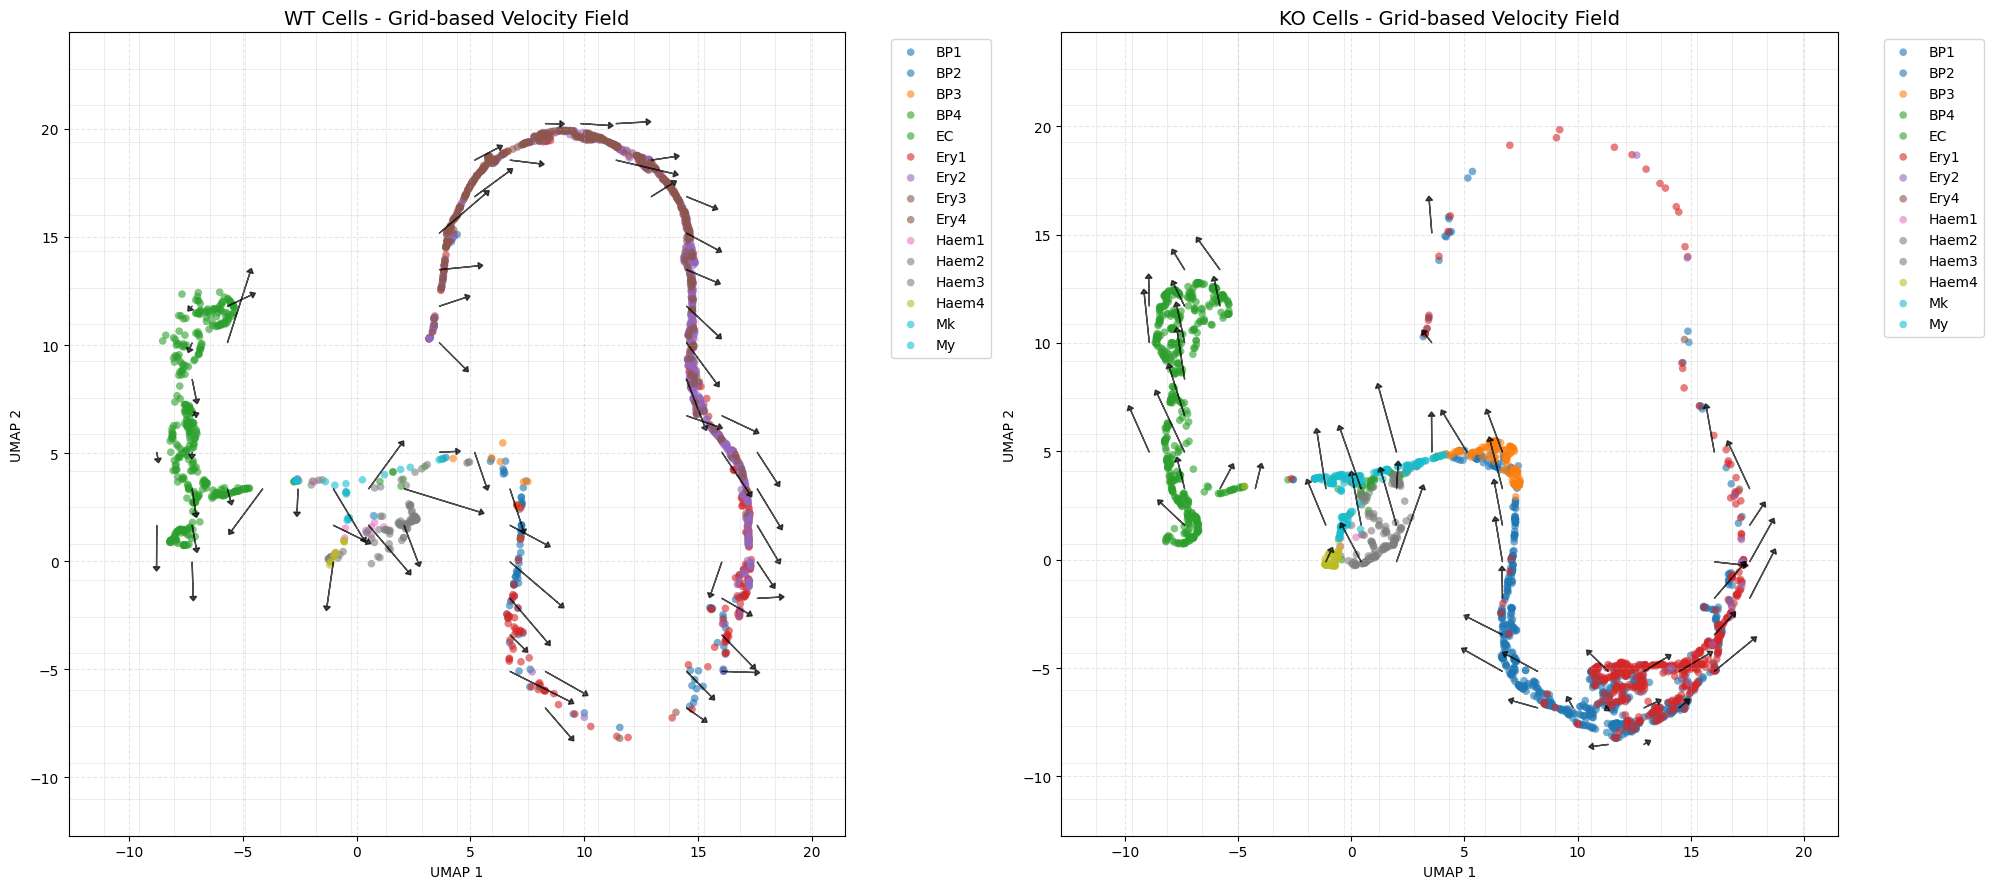

WT: 65 grids with velocity vectors
KO: 56 grids with velocity vectors
Average cells per grid (WT): 31.5
Average cells per grid (KO): 39.8
Average velocity magnitude (WT): 0.060645
Average velocity magnitude (KO): 0.061188


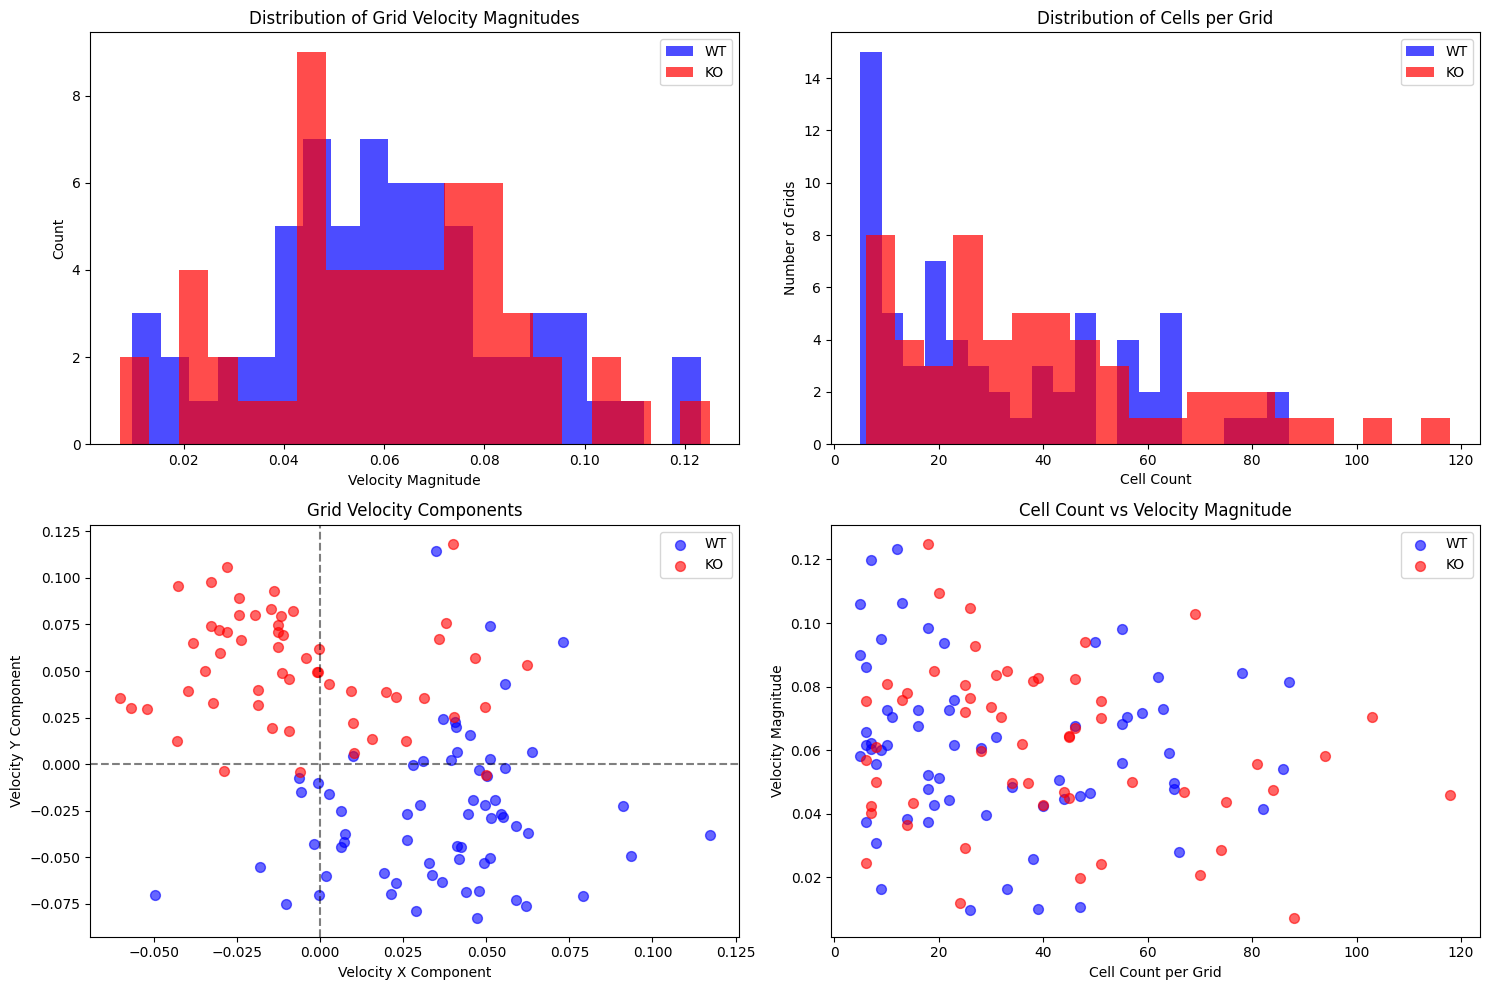

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import scvelo as scv
from scipy.stats import binned_statistic_2d
from matplotlib.colors import Normalize
import seaborn as sns

def compute_grid_velocities_with_transitions(X, V, grid_size=20, min_cells=5):
    """
    グリッドベースの速度場を計算し、遷移確率も考慮
    
    Returns:
    --------
    X_grid: グリッドの中心座標
    V_grid: グリッドの平均速度ベクトル
    cell_counts: 各グリッドの細胞数
    grid_edges: グリッドのエッジ座標
    transition_probs: グリッド間の遷移確率（オプション）
    """
    # 座標の範囲を取得
    x_min, x_max = X[:, 0].min(), X[:, 0].max()
    y_min, y_max = X[:, 1].min(), X[:, 1].max()
    
    # マージンを追加
    margin_x = (x_max - x_min) * 0.1
    margin_y = (y_max - y_min) * 0.1
    x_min -= margin_x
    x_max += margin_x
    y_min -= margin_y
    y_max += margin_y
    
    # グリッドのエッジを定義
    x_edges = np.linspace(x_min, x_max, grid_size + 1)
    y_edges = np.linspace(y_min, y_max, grid_size + 1)
    
    # 各グリッドの中心座標を計算
    x_centers = (x_edges[:-1] + x_edges[1:]) / 2
    y_centers = (y_edges[:-1] + y_edges[1:]) / 2
    xx, yy = np.meshgrid(x_centers, y_centers)
    X_grid = np.column_stack([xx.ravel(), yy.ravel()])
    
    # 各グリッドの統計量を計算
    vx_mean, _, _, _ = binned_statistic_2d(
        X[:, 0], X[:, 1], V[:, 0], 
        statistic='mean', bins=[x_edges, y_edges]
    )
    
    vy_mean, _, _, _ = binned_statistic_2d(
        X[:, 0], X[:, 1], V[:, 1], 
        statistic='mean', bins=[x_edges, y_edges]
    )
    
    cell_counts, _, _, _ = binned_statistic_2d(
        X[:, 0], X[:, 1], V[:, 0], 
        statistic='count', bins=[x_edges, y_edges]
    )
    
    # グリッドベースの速度ベクトルを作成
    V_grid = np.zeros((grid_size * grid_size, 2))
    V_grid[:, 0] = vx_mean.T.ravel()
    V_grid[:, 1] = vy_mean.T.ravel()
    
    # NaNを0に置換
    V_grid = np.nan_to_num(V_grid)
    cell_counts = cell_counts.T.ravel()
    
    # 細胞数が少ないグリッドをマスク
    mask = cell_counts >= min_cells
    
    return X_grid[mask], V_grid[mask], cell_counts[mask], (x_edges, y_edges), mask

def plot_latent_space_with_grid_velocity_complete(
    wt_embedding, ko_embedding, wt_labels_np, ko_labels_np, cell_type_names,
    adata_wt_aligned, adata_ko_aligned, grid_size=20, min_cells=5, 
    arrow_scale=30, show_grid=True, show_cell_counts=False
):
    """
    要件を全て満たすグリッドベース速度場の可視化
    
    Parameters:
    -----------
    grid_size: グリッドのサイズ（各軸の分割数）
    min_cells: グリッド内の最小細胞数
    arrow_scale: 矢印のスケール
    show_grid: グリッド線を表示するか
    show_cell_counts: 各グリッドの細胞数を表示するか
    """
    # カラーマップの設定
    n_cell_types = len(cell_type_names)
    colors = plt.cm.tab10(np.linspace(0, 1, n_cell_types))
    
    # adataのコピーを作成
    adata_wt_copy = adata_wt_aligned.copy()
    adata_ko_copy = adata_ko_aligned.copy()
    
    # VAEで計算したUMAP座標をadataに設定
    adata_wt_copy.obsm['X_umap'] = wt_embedding
    adata_ko_copy.obsm['X_umap'] = ko_embedding
    
    # velocity_embeddingが未計算の場合は計算
    try:
        if 'velocity_umap' not in adata_wt_copy.obsm:
            print("WTのvelocity_embeddingを計算中...")
            scv.tl.velocity_embedding(adata_wt_copy, basis='umap')
        if 'velocity_umap' not in adata_ko_copy.obsm:
            print("KOのvelocity_embeddingを計算中...")
            scv.tl.velocity_embedding(adata_ko_copy, basis='umap')
    except Exception as e:
        print(f"velocity_embedding計算中にエラー: {e}")
        return
    
    # 可視化
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 9))
    
    # WT細胞の可視化
    for i, ct in enumerate(range(n_cell_types)):
        mask = wt_labels_np == ct
        if np.sum(mask) > 0:
            ax1.scatter(
                wt_embedding[mask, 0], 
                wt_embedding[mask, 1],
                c=[colors[i]],
                label=cell_type_names[ct],
                s=30,
                alpha=0.6,
                edgecolor='none'
            )
    
    # WTのグリッドベース速度場を計算
    X_wt = adata_wt_copy.obsm['X_umap']
    V_wt = adata_wt_copy.obsm['velocity_umap']
    
    X_grid_wt, V_grid_wt, counts_wt, edges_wt, mask_wt = compute_grid_velocities_with_transitions(
        X_wt, V_wt, grid_size=grid_size, min_cells=min_cells
    )
    
    # グリッド線の表示
    if show_grid:
        x_edges, y_edges = edges_wt
        for x in x_edges:
            ax1.axvline(x, color='gray', alpha=0.2, linewidth=0.5)
        for y in y_edges:
            ax1.axhline(y, color='gray', alpha=0.2, linewidth=0.5)
    
    # 細胞数の表示（オプション）
    if show_cell_counts:
        for i, (x, y) in enumerate(X_grid_wt):
            ax1.text(x, y, str(int(counts_wt[i])), 
                    fontsize=8, ha='center', va='center',
                    bbox=dict(boxstyle="round,pad=0.3", facecolor='white', alpha=0.5))
    
    # 速度ベクトルの描画（矢印）
    for i in range(len(X_grid_wt)):
        ax1.arrow(
            X_grid_wt[i, 0], X_grid_wt[i, 1],
            V_grid_wt[i, 0] * arrow_scale, V_grid_wt[i, 1] * arrow_scale,
            head_width=0.3,
            head_length=0.2,
            fc='black',
            ec='black',
            alpha=0.7,
            length_includes_head=True
        )
    
    # 軸メモリの設定
    ax1.set_title('WT Cells - Grid-based Velocity Field', fontsize=14)
    ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax1.set_xlabel('UMAP 1')
    ax1.set_ylabel('UMAP 2')
    ax1.grid(True, linestyle='--', alpha=0.3)
    ax1.tick_params(axis='both', which='major', labelsize=10)
    
    # KO細胞の可視化（同様の処理）
    for i, ct in enumerate(range(n_cell_types)):
        mask = ko_labels_np == ct
        if np.sum(mask) > 0:
            ax2.scatter(
                ko_embedding[mask, 0], 
                ko_embedding[mask, 1],
                c=[colors[i]],
                label=cell_type_names[ct],
                s=30,
                alpha=0.6,
                edgecolor='none'
            )
    
    # KOのグリッドベース速度場を計算
    X_ko = adata_ko_copy.obsm['X_umap']
    V_ko = adata_ko_copy.obsm['velocity_umap']
    
    X_grid_ko, V_grid_ko, counts_ko, edges_ko, mask_ko = compute_grid_velocities_with_transitions(
        X_ko, V_ko, grid_size=grid_size, min_cells=min_cells
    )
    
    # グリッド線の表示
    if show_grid:
        x_edges, y_edges = edges_ko
        for x in x_edges:
            ax2.axvline(x, color='gray', alpha=0.2, linewidth=0.5)
        for y in y_edges:
            ax2.axhline(y, color='gray', alpha=0.2, linewidth=0.5)
    
    # 細胞数の表示（オプション）
    if show_cell_counts:
        for i, (x, y) in enumerate(X_grid_ko):
            ax2.text(x, y, str(int(counts_ko[i])), 
                    fontsize=8, ha='center', va='center',
                    bbox=dict(boxstyle="round,pad=0.3", facecolor='white', alpha=0.5))
    
    # 速度ベクトルの描画（矢印）
    for i in range(len(X_grid_ko)):
        ax2.arrow(
            X_grid_ko[i, 0], X_grid_ko[i, 1],
            V_grid_ko[i, 0] * arrow_scale, V_grid_ko[i, 1] * arrow_scale,
            head_width=0.3,
            head_length=0.2,
            fc='black',
            ec='black',
            alpha=0.7,
            length_includes_head=True
        )
    
    # 軸メモリの設定
    ax2.set_title('KO Cells - Grid-based Velocity Field', fontsize=14)
    ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax2.set_xlabel('UMAP 1')
    ax2.set_ylabel('UMAP 2')
    ax2.grid(True, linestyle='--', alpha=0.3)
    ax2.tick_params(axis='both', which='major', labelsize=10)
    
    plt.tight_layout()
    plt.show()
    
    # 統計情報を表示
    print(f"WT: {len(X_grid_wt)} grids with velocity vectors")
    print(f"KO: {len(X_grid_ko)} grids with velocity vectors")
    print(f"Average cells per grid (WT): {counts_wt.mean():.1f}")
    print(f"Average cells per grid (KO): {counts_ko.mean():.1f}")
    
    # 速度の統計情報
    v_mag_wt = np.linalg.norm(V_grid_wt, axis=1)
    v_mag_ko = np.linalg.norm(V_grid_ko, axis=1)
    print(f"Average velocity magnitude (WT): {v_mag_wt.mean():.6f}")
    print(f"Average velocity magnitude (KO): {v_mag_ko.mean():.6f}")
    
    # 詳細な統計プロットも作成
    plot_grid_statistics(V_grid_wt, V_grid_ko, counts_wt, counts_ko)

def plot_grid_statistics(V_grid_wt, V_grid_ko, counts_wt, counts_ko):
    """グリッドごとの統計情報を可視化"""
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # 速度の大きさの分布
    v_mag_wt = np.linalg.norm(V_grid_wt, axis=1)
    v_mag_ko = np.linalg.norm(V_grid_ko, axis=1)
    
    axes[0, 0].hist(v_mag_wt, bins=20, alpha=0.7, label='WT', color='blue')
    axes[0, 0].hist(v_mag_ko, bins=20, alpha=0.7, label='KO', color='red')
    axes[0, 0].set_xlabel('Velocity Magnitude')
    axes[0, 0].set_ylabel('Count')
    axes[0, 0].set_title('Distribution of Grid Velocity Magnitudes')
    axes[0, 0].legend()
    
    # 細胞数の分布
    axes[0, 1].hist(counts_wt, bins=20, alpha=0.7, label='WT', color='blue')
    axes[0, 1].hist(counts_ko, bins=20, alpha=0.7, label='KO', color='red')
    axes[0, 1].set_xlabel('Cell Count')
    axes[0, 1].set_ylabel('Number of Grids')
    axes[0, 1].set_title('Distribution of Cells per Grid')
    axes[0, 1].legend()
    
    # 速度成分の散布図
    axes[1, 0].scatter(V_grid_wt[:, 0], V_grid_wt[:, 1], 
                      alpha=0.6, label='WT', color='blue', s=50)
    axes[1, 0].scatter(V_grid_ko[:, 0], V_grid_ko[:, 1], 
                      alpha=0.6, label='KO', color='red', s=50)
    axes[1, 0].set_xlabel('Velocity X Component')
    axes[1, 0].set_ylabel('Velocity Y Component')
    axes[1, 0].set_title('Grid Velocity Components')
    axes[1, 0].legend()
    axes[1, 0].axhline(y=0, color='k', linestyle='--', alpha=0.5)
    axes[1, 0].axvline(x=0, color='k', linestyle='--', alpha=0.5)
    
    # 細胞数 vs 速度の大きさ
    axes[1, 1].scatter(counts_wt, v_mag_wt, alpha=0.6, label='WT', color='blue', s=50)
    axes[1, 1].scatter(counts_ko, v_mag_ko, alpha=0.6, label='KO', color='red', s=50)
    axes[1, 1].set_xlabel('Cell Count per Grid')
    axes[1, 1].set_ylabel('Velocity Magnitude')
    axes[1, 1].set_title('Cell Count vs Velocity Magnitude')
    axes[1, 1].legend()
    
    plt.tight_layout()
    plt.show()

def visualize_transition_probabilities(adata, grid_size=15):
    """グリッド間の遷移確率を可視化（追加機能）"""
    X = adata.obsm['X_umap']
    V = adata.obsm['velocity_umap']
    
    # グリッドを作成
    x_min, x_max = X[:, 0].min(), X[:, 0].max()
    y_min, y_max = X[:, 1].min(), X[:, 1].max()
    
    # グリッドのビン
    x_bins = np.linspace(x_min, x_max, grid_size + 1)
    y_bins = np.linspace(y_min, y_max, grid_size + 1)
    
    # 各細胞の現在のグリッド位置
    x_idx = np.digitize(X[:, 0], x_bins) - 1
    y_idx = np.digitize(X[:, 1], y_bins) - 1
    
    # 速度に基づく次の位置
    X_next = X + V
    x_next_idx = np.digitize(X_next[:, 0], x_bins) - 1
    y_next_idx = np.digitize(X_next[:, 1], y_bins) - 1
    
    # 遷移行列を構築
    transition_matrix = np.zeros((grid_size * grid_size, grid_size * grid_size))
    
    for i in range(len(X)):
        if (0 <= x_idx[i] < grid_size and 0 <= y_idx[i] < grid_size and
            0 <= x_next_idx[i] < grid_size and 0 <= y_next_idx[i] < grid_size):
            
            current_idx = y_idx[i] * grid_size + x_idx[i]
            next_idx = y_next_idx[i] * grid_size + x_next_idx[i]
            transition_matrix[current_idx, next_idx] += 1
    
    # 正規化（行の和が1になるように）
    row_sums = transition_matrix.sum(axis=1)
    row_sums[row_sums == 0] = 1  # ゼロ除算を避ける
    transition_matrix = transition_matrix / row_sums[:, np.newaxis]
    
    # ヒートマップとして可視化
    plt.figure(figsize=(10, 8))
    sns.heatmap(transition_matrix, cmap='viridis', vmin=0, vmax=0.1)
    plt.title('Grid-to-Grid Transition Probabilities')
    plt.xlabel('Next Grid Index')
    plt.ylabel('Current Grid Index')
    plt.show()
    
    return transition_matrix

# 使用例
# メインの可視化
plot_latent_space_with_grid_velocity_complete(
    wt_embedding, ko_embedding, wt_labels_np, ko_labels_np, cell_type_names,
    adata_wt_aligned, adata_ko_aligned, 
    grid_size=20,         # グリッドのサイズ
    min_cells=5,          # 最小細胞数
    arrow_scale=30,       # 矢印のスケール
    show_grid=True,       # グリッド線を表示
    show_cell_counts=False  # 細胞数を表示
)

